In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lombscargle
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from arch import arch_model

colours = {
    'cucumbers': '#4daf4a', # Green
    'guitars': '#f781bf',      # Pink
    'slingshots': '#984ea3',  # Purple
    'stocks': '#e41a1c',  # Red
    'sugar': '#ff7f00',      # Orange
    'water': '#377eb8',    # Blue
    'tranquillity': '#a65628' # Brown
}

# === Load and Clean Data ===
df = pd.read_csv("spiff_data.csv")
df = df.dropna(how='all', axis=1).dropna(how='all', axis=0)
df.replace(1000, np.nan, inplace=True)
df=df.drop(columns='Unnamed: 0')
df.rename(columns={'gurkor':'cucumbers'}, inplace=True)
# Save the cleaned dataframe to a new CSV file
df.to_csv('spiff_data_cleaned.csv', index=False)

# === Compute Log Returns ===
log_returns = np.log(df / df.shift(1))

In [78]:
df.head()

,day,cucumbers,guitars,slingshots,stocks,sugar,water,tranquillity
0,1.0,6.154653,2.794285,2.136536,10.653684,3.324896,3.896149,7.755880
1,2.0,6.189623,2.843068,2.113582,10.674465,3.355736,3.899915,7.781310
2,3.0,6.168641,2.839644,2.116336,10.822372,3.336461,3.897404,7.886205
3,4.0,6.156401,2.823384,2.096137,10.848804,3.288274,3.901170,7.848061
4,5.0,6.124929,2.832798,2.099810,10.860731,3.303694,3.905355,7.883026


In [79]:
summary_stats = df.describe()
summary_stats

,day,cucumbers,guitars,slingshots,stocks,sugar,water,tranquillity
count,5455.000000,5201.000000,5201.000000,5201.000000,5201.000000,5201.000000,5201.000000,5201.000000
mean,2728.816865,8.934701,5.758999,3.562496,6.354767,2.663530,5.794586,11.552924
std,1575.126349,2.268289,1.756993,0.973406,2.139400,0.727010,1.275024,3.067634
min,1.000000,5.942896,2.629048,2.001362,4.012346,1.370262,3.739412,6.614749
25%,1365.500000,6.947150,4.252728,2.804869,4.916920,1.999030,4.996563,9.186268
50%,2729.000000,8.905505,5.907840,3.383130,5.520531,2.605522,5.774852,10.584870
75%,4092.500000,10.183919,7.055568,4.291411,6.946382,3.279982,6.488217,13.380483
max,5456.000000,14.132395,10.719387,6.468982,13.613052,4.125193,8.949187,21.137953


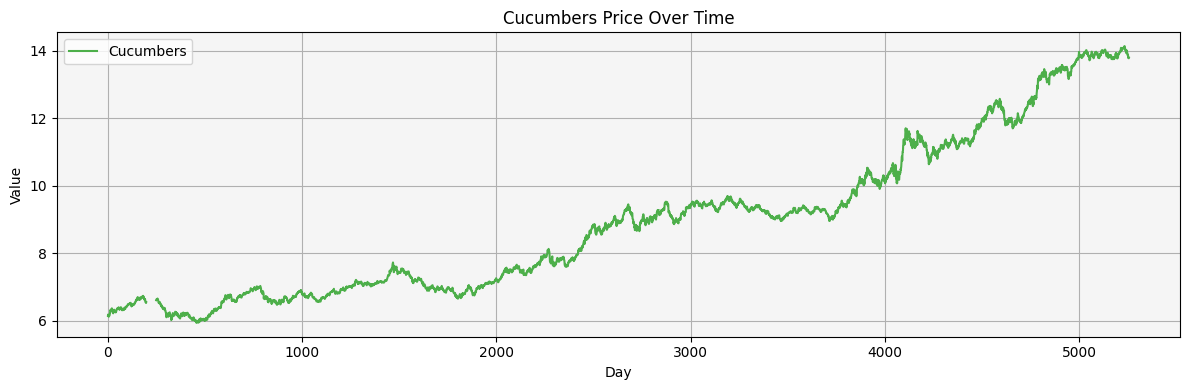

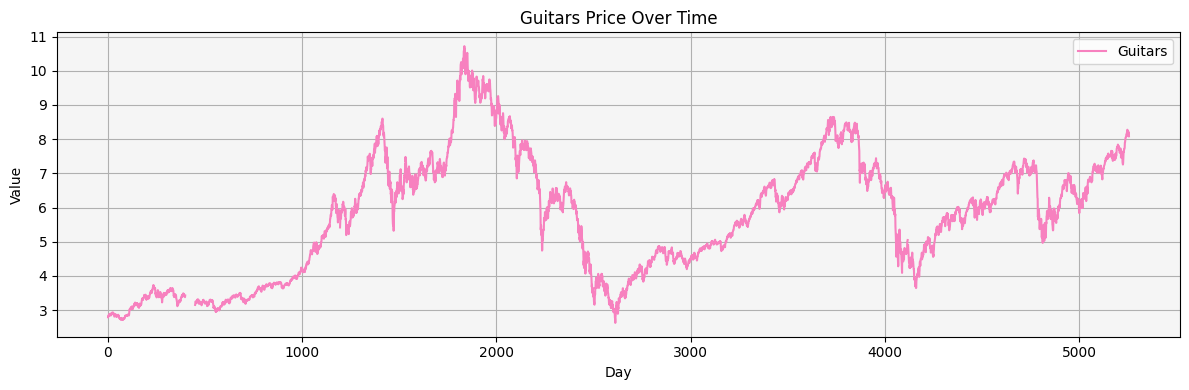

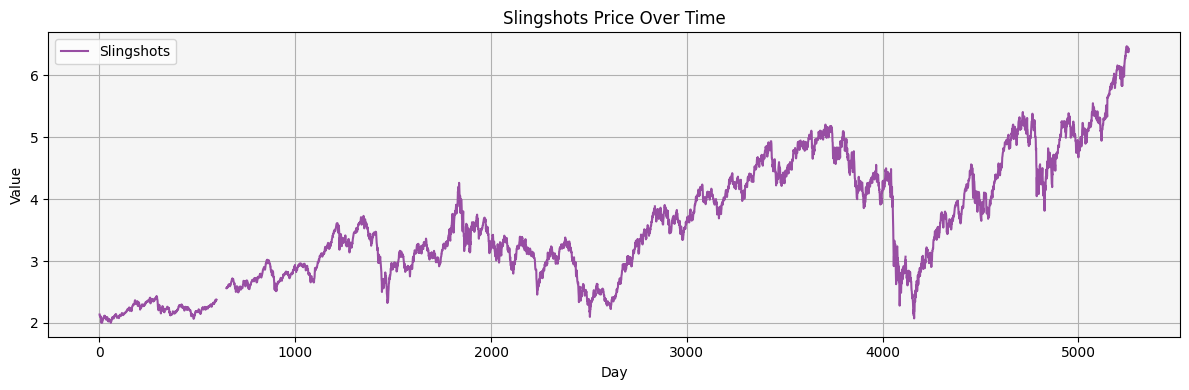

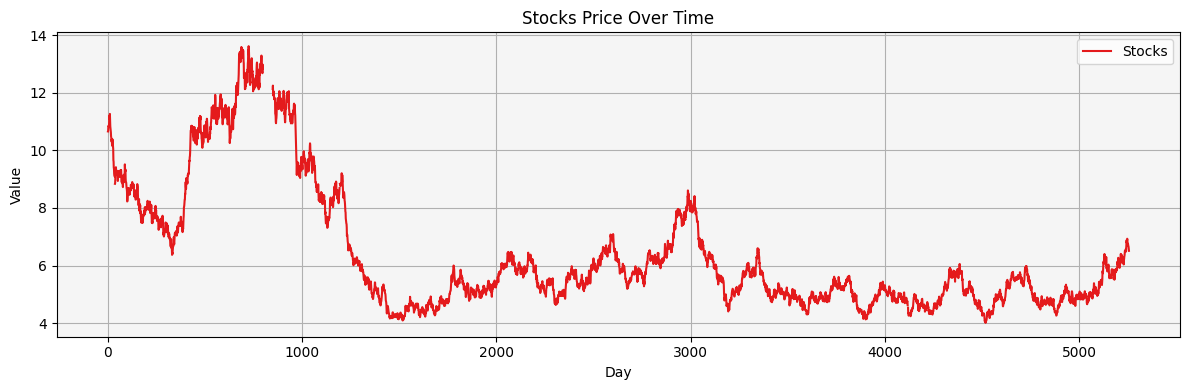

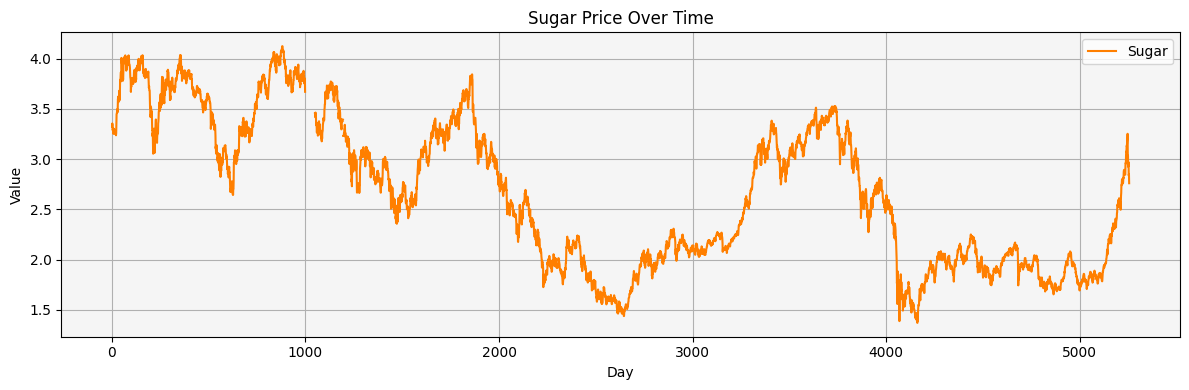

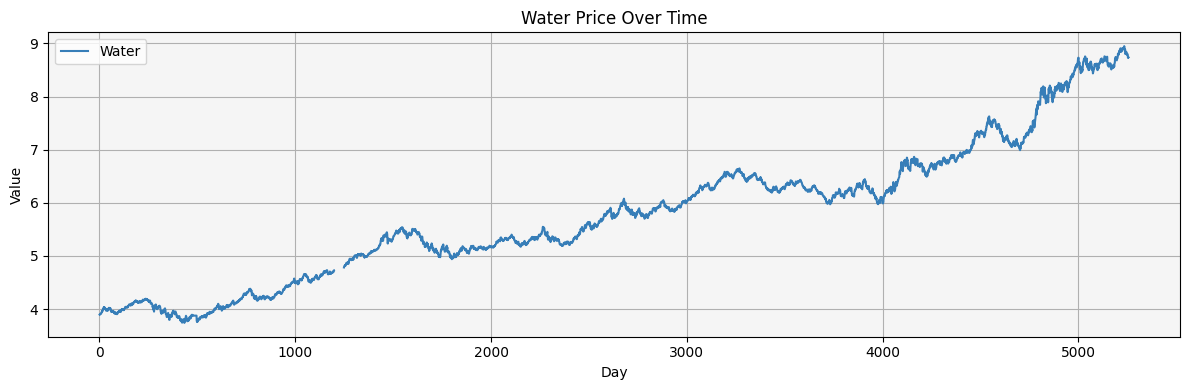

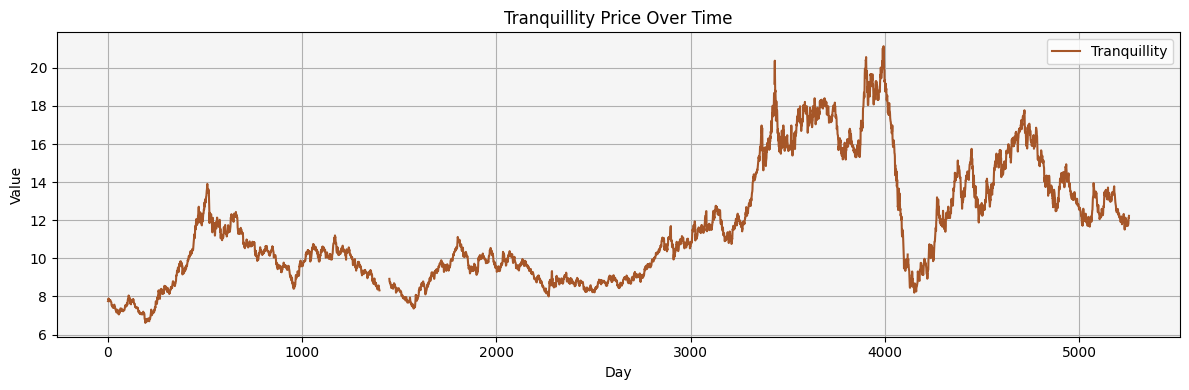

In [80]:
# Create a separate plot for each column
for column, color in colours.items():
    plt.figure(figsize=(12, 4))
    plt.plot(df['day'], df[column], color=color, label=column.capitalize())
    plt.title(f'{column.capitalize()} Price Over Time')
    plt.xlabel('Day')
    plt.ylabel('Value')
    plt.grid(True)
    plt.gca().set_facecolor("whitesmoke")
    plt.legend()
    plt.tight_layout()
    plt.show()

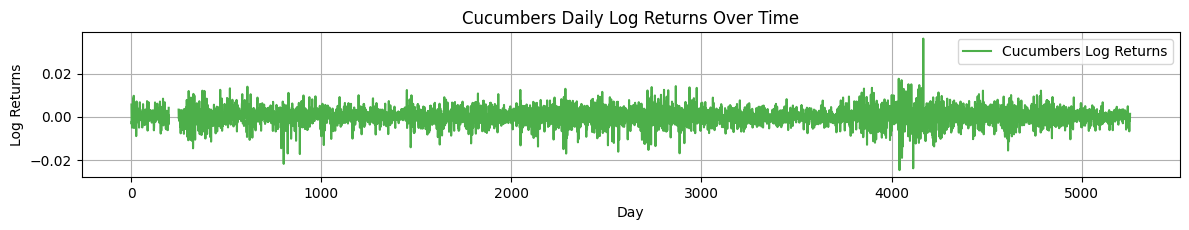

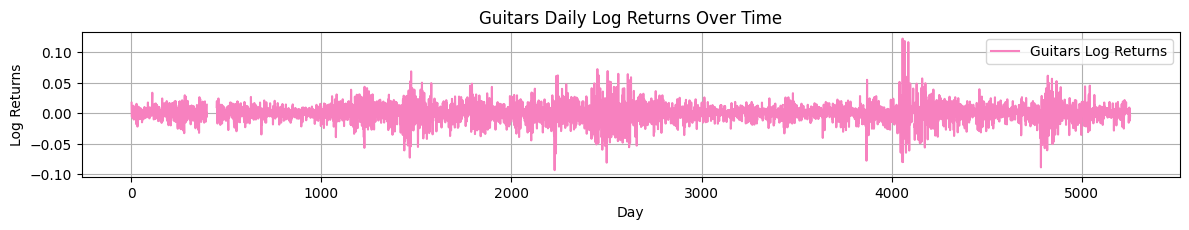

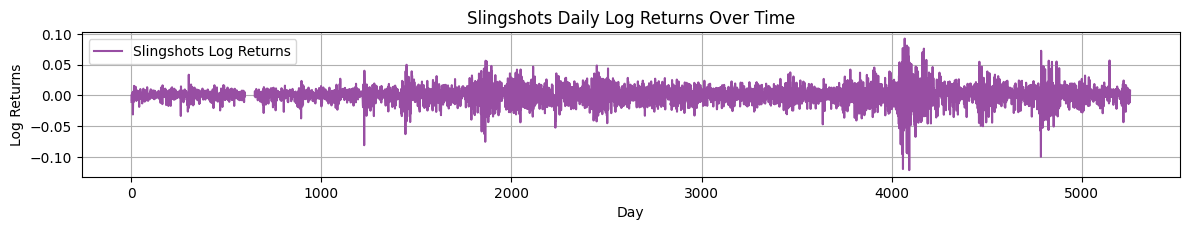

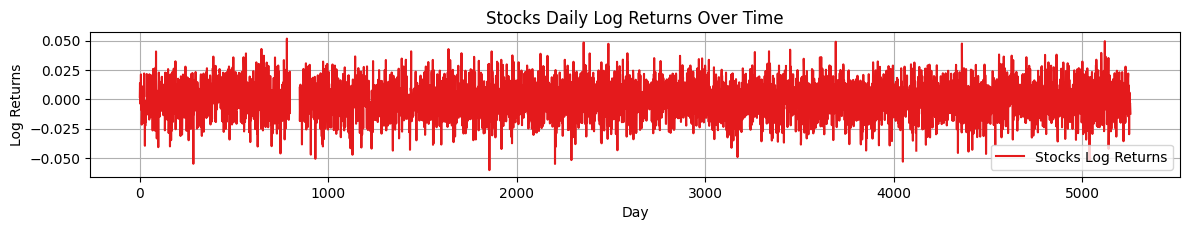

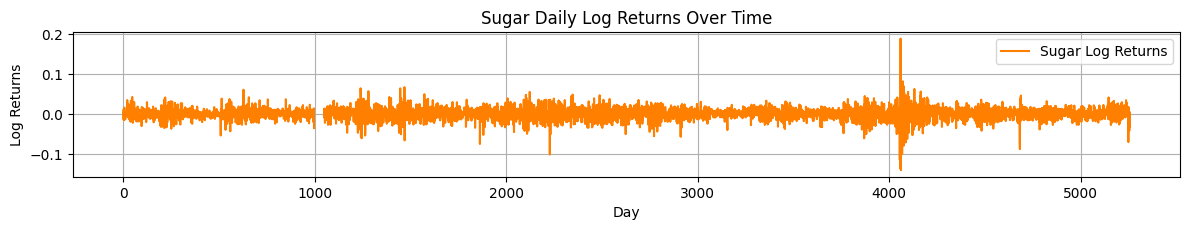

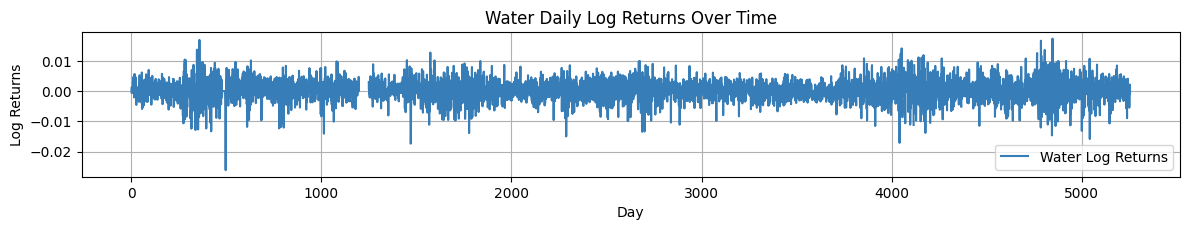

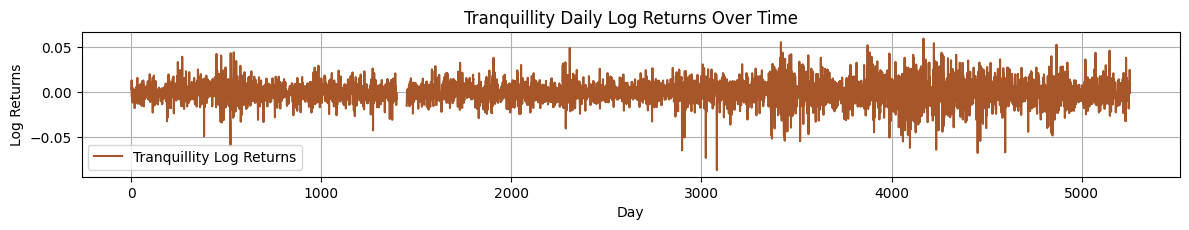

In [81]:
# Loop through each column for plotting
for column, color in colours.items():
    plt.figure(figsize=(12, 4))
    # Plot log returns
    plt.subplot(2, 1, 2)
    plt.plot(log_returns[column], color=color, label=f'{column.capitalize()} Log Returns')
    plt.title(f'{column.capitalize()} Daily Log Returns Over Time')
    plt.xlabel('Day')
    plt.ylabel('Log Returns')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

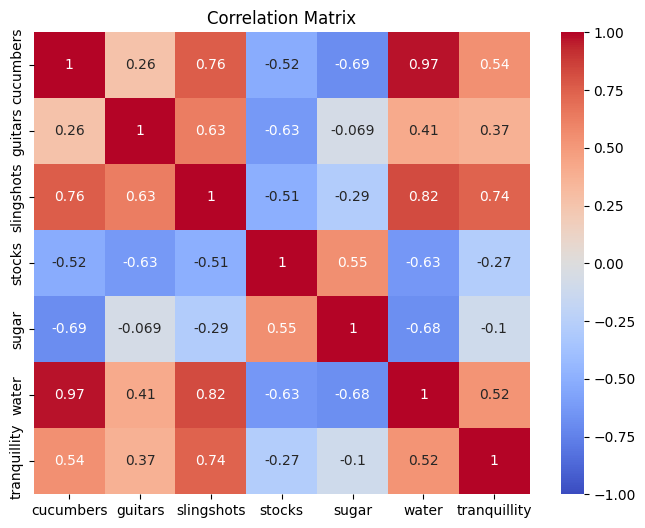

In [148]:
corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

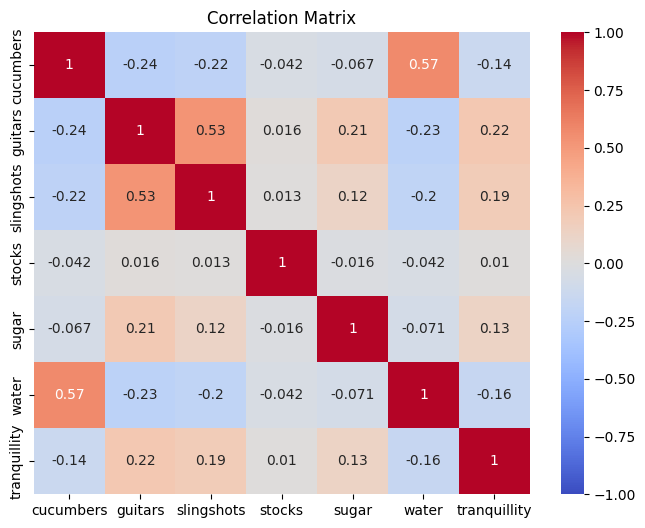

In [82]:
df=df.dropna()
plt.figure(figsize=(8,6))
sns.heatmap(log_returns.drop(columns='day').corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

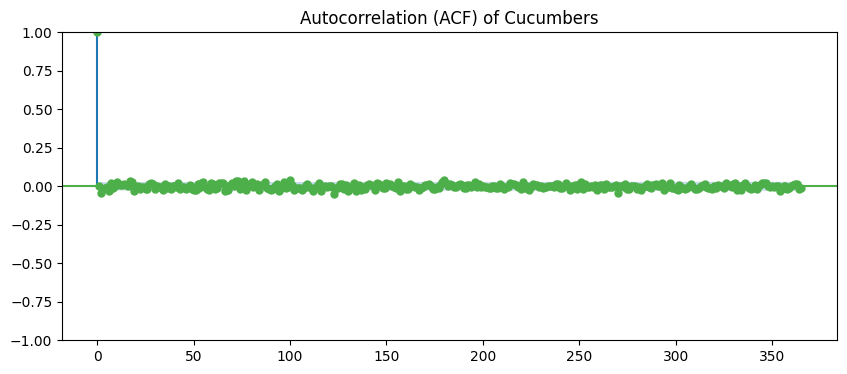

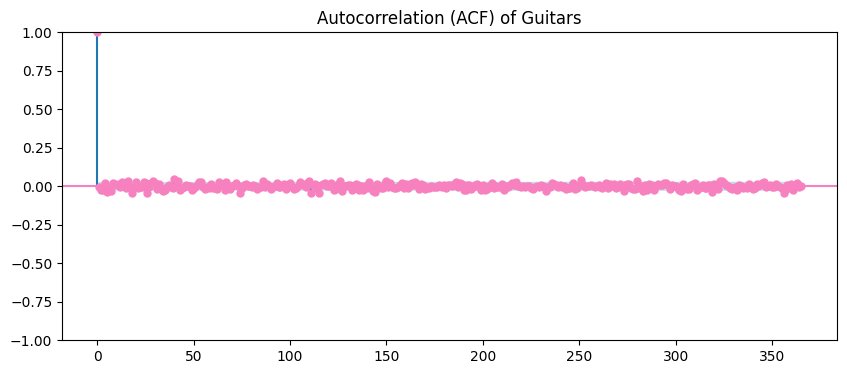

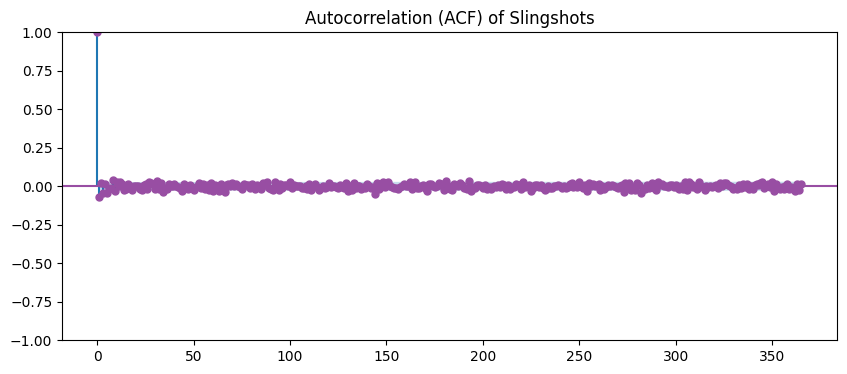

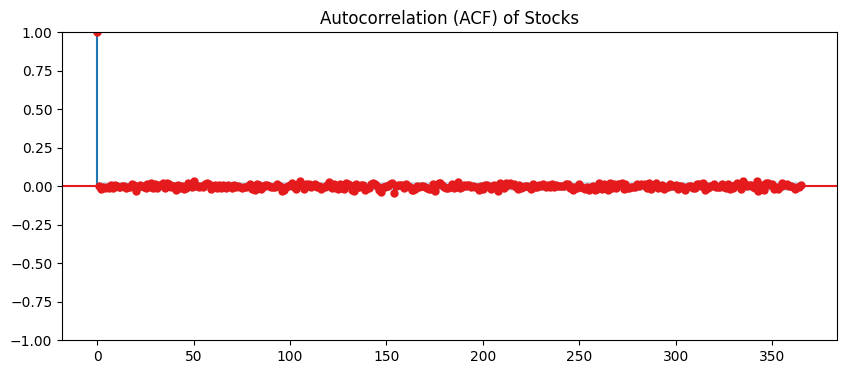

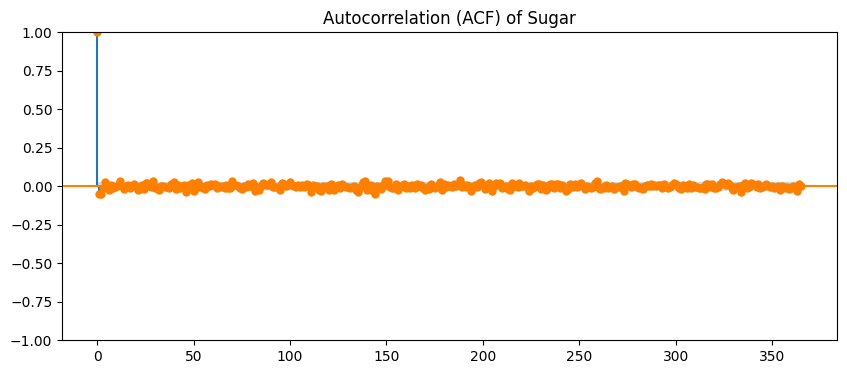

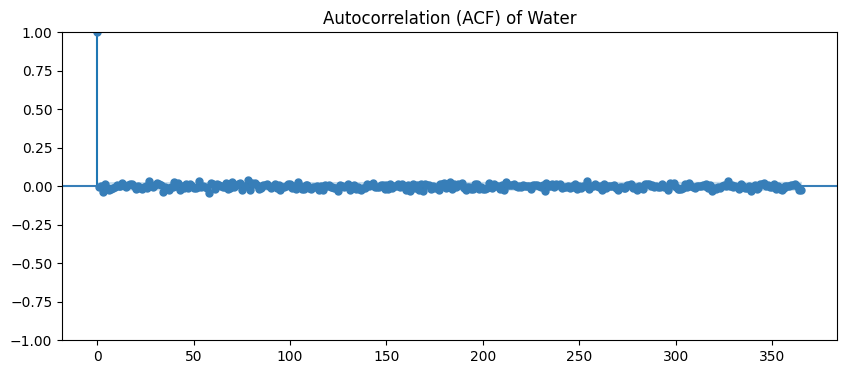

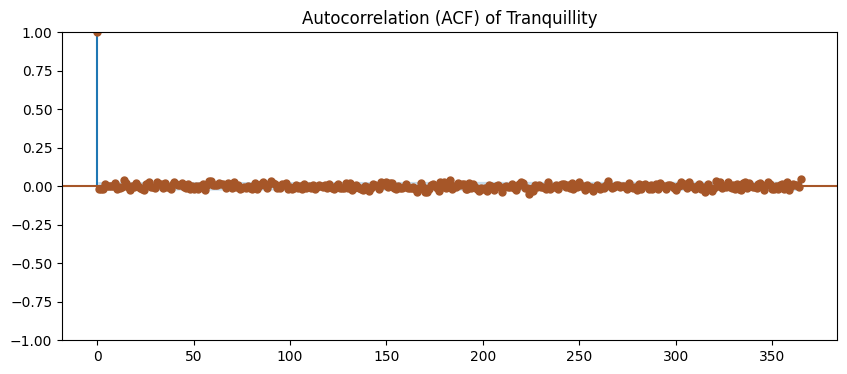

In [158]:
from statsmodels.graphics.tsaplots import plot_acf

for column, color in colours.items():
    series = log_returns[column].dropna()
    fig, ax = plt.subplots(figsize=(10, 4))
    plot_acf(series, ax=ax, lags=365, alpha=0.05, color=color)
    ax.set_title(f'Autocorrelation (ACF) of {column.capitalize()}')
    plt.show()


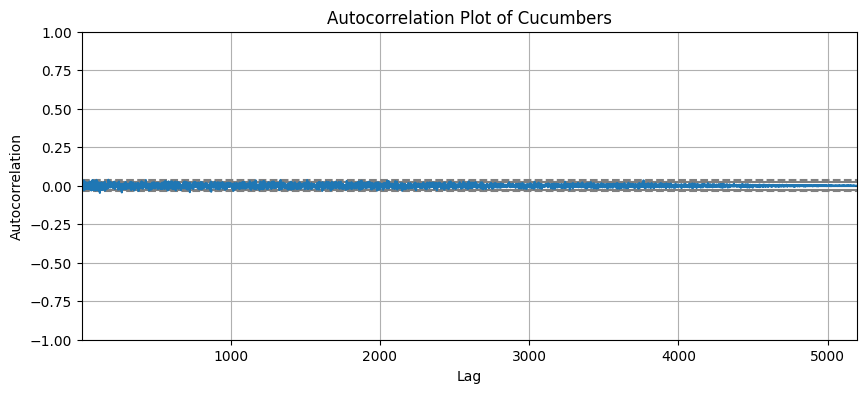

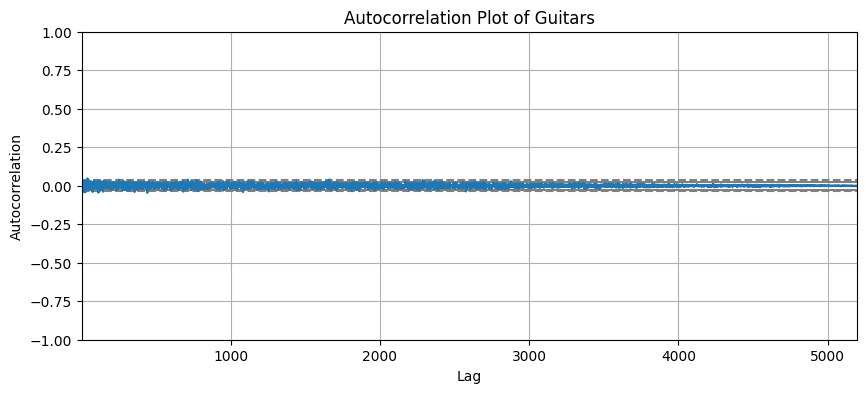

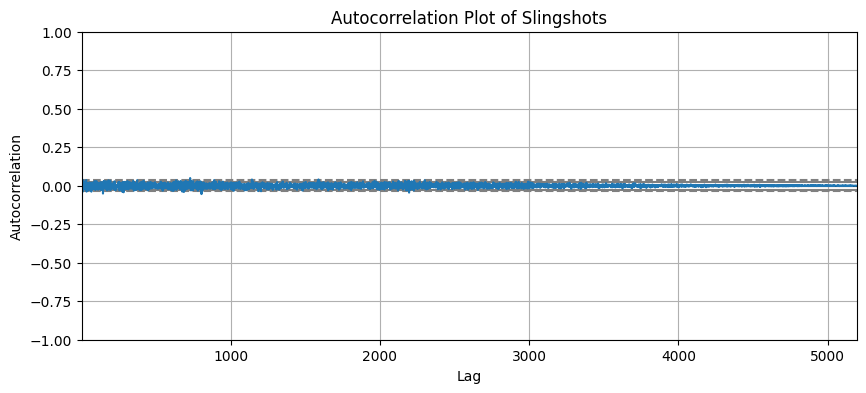

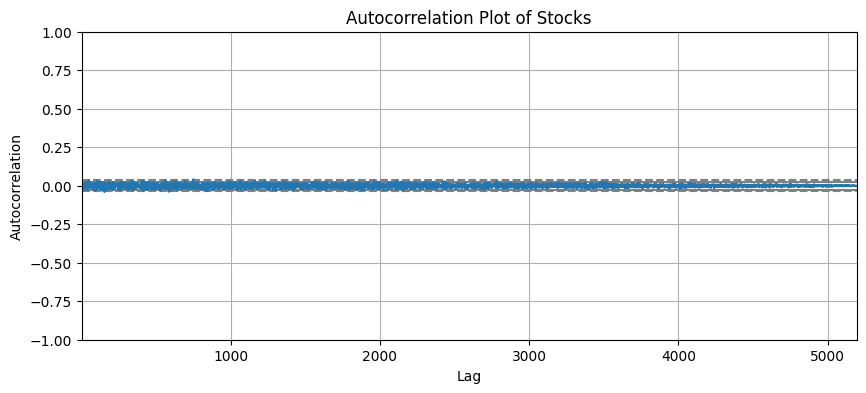

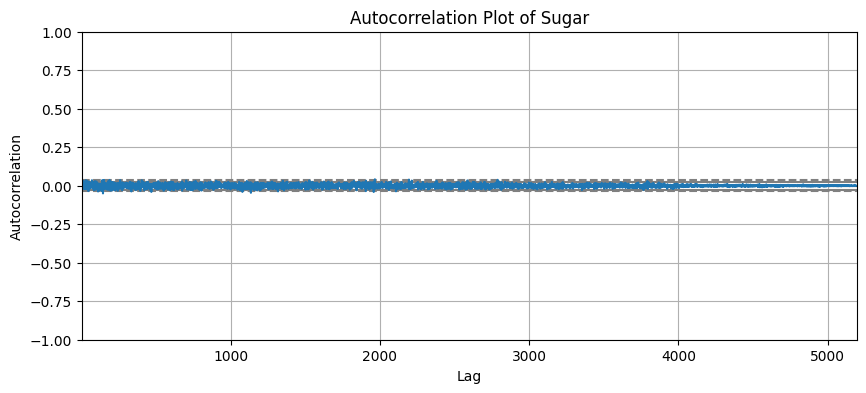

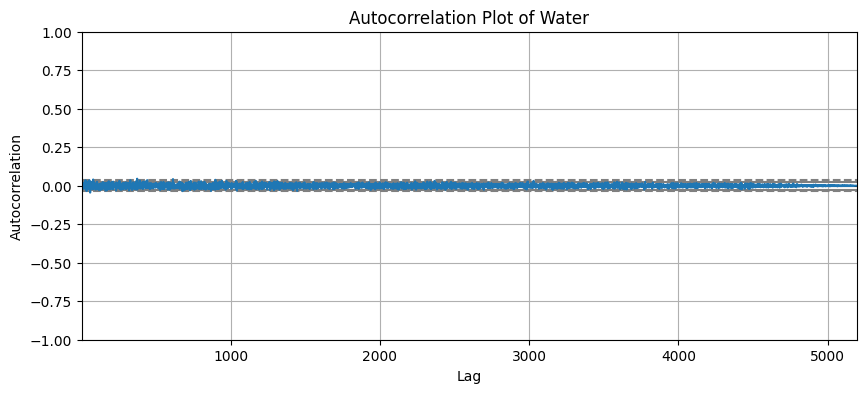

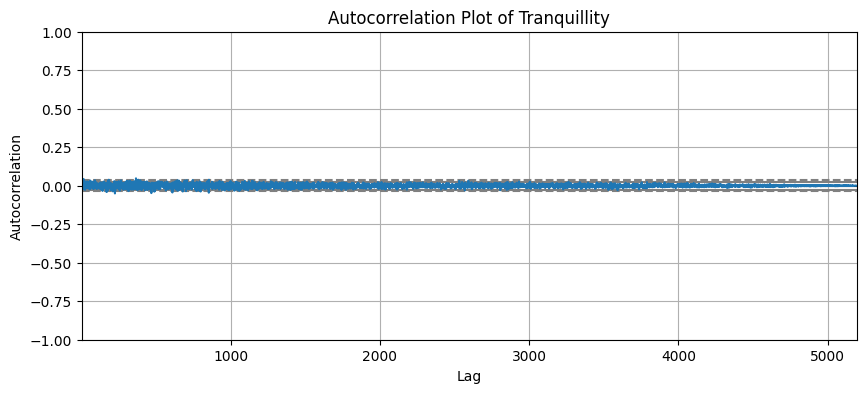

In [153]:
from pandas.plotting import autocorrelation_plot

for column, color in colours.items():
    series = log_returns[column].dropna()
    plt.figure(figsize=(10,4))
    autocorrelation_plot(series)
    plt.title(f'Autocorrelation Plot of {column.capitalize()}')
    plt.show()


In [149]:
from statsmodels.tsa.stattools import acf

# Function to find the best seasonal lag based on the highest significant autocorrelation peak
def best_seasonal_lag(series, max_lag=365):
    acf_values, confint = acf(series, nlags=max_lag, alpha=0.05)
    # Ignore lag 0 and find the lag with the highest autocorrelation above confidence interval
    significant_lags = [(lag, val) for lag, val in enumerate(acf_values[1:], 1) if val > confint[lag][1]]
    if significant_lags:
        best_lag = max(significant_lags, key=lambda x: x[1])[0]
        return best_lag
    else:
        return None

# Find best seasonal lag for each time series
best_lags = {}
max_lag_to_check = 365*7
for col in df.columns:
    lag = best_seasonal_lag(df[f'{col}'], max_lag=max_lag_to_check)
    best_lags[col] = lag

best_lags

{'cucumbers': None,
 'guitars': None,
 'slingshots': None,
 'stocks': None,
 'sugar': None,
 'water': None,
 'tranquillity': None}

Instrument: cucumbers
Significant integer periods (no duplicates): [ 55  59  64  68  71  78  80  83  85  90  95 102 111 113 121 125 131 136
 149 156 163 172 187 208 221 238 256 304 327 354 386 427 478 606]
Detailed significant peaks:
  Period = 606.06 days, Power = 0.0074, FAP = 0.00023
  Period = 477.94 days, Power = 0.0181, FAP = 0.00000
  Period = 426.93 days, Power = 0.0111, FAP = 0.00000
  Period = 385.76 days, Power = 0.0182, FAP = 0.00000
  Period = 354.22 days, Power = 0.0101, FAP = 0.00000
  Period = 327.46 days, Power = 0.0458, FAP = 0.00000
  Period = 304.45 days, Power = 0.0203, FAP = 0.00000
  Period = 256.41 days, Power = 0.0642, FAP = 0.00000
  Period = 237.66 days, Power = 0.0687, FAP = 0.00000
  Period = 220.53 days, Power = 0.0526, FAP = 0.00000
  Period = 208.17 days, Power = 0.0790, FAP = 0.00000
  Period = 187.19 days, Power = 0.1180, FAP = 0.00000
  Period = 171.73 days, Power = 0.0243, FAP = 0.00000
  Period = 162.60 days, Power = 0.0123, FAP = 0.00000
  Period =

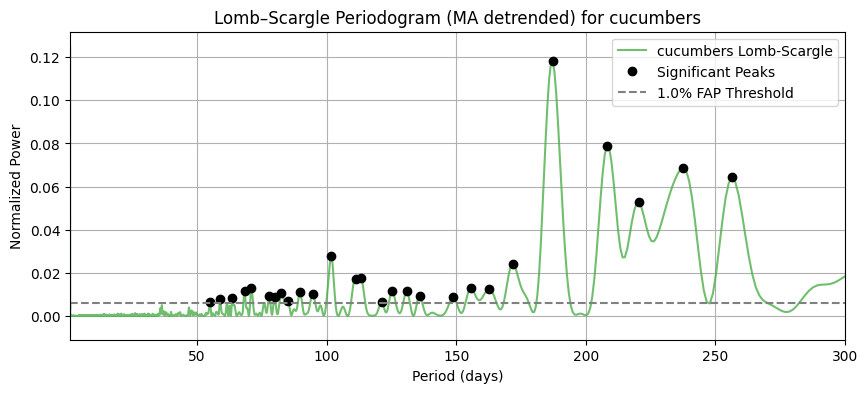

Instrument: guitars
Significant integer periods (no duplicates): [ 55  57  59  61  66  80  82  87  92  95 101 104 107 111 115 122 127 134
 141 147 154 163 171 185 196 207 221 238 256 273 319 362 401 482 660 828]
Detailed significant peaks:
  Period = 828.03 days, Power = 0.0147, FAP = 0.00000
  Period = 659.90 days, Power = 0.0079, FAP = 0.00007
  Period = 482.37 days, Power = 0.0304, FAP = 0.00000
  Period = 400.62 days, Power = 0.0113, FAP = 0.00000
  Period = 361.61 days, Power = 0.0084, FAP = 0.00002
  Period = 319.41 days, Power = 0.0318, FAP = 0.00000
  Period = 272.54 days, Power = 0.0119, FAP = 0.00000
  Period = 256.41 days, Power = 0.0572, FAP = 0.00000
  Period = 237.66 days, Power = 0.0831, FAP = 0.00000
  Period = 221.47 days, Power = 0.0428, FAP = 0.00000
  Period = 206.51 days, Power = 0.0197, FAP = 0.00000
  Period = 196.37 days, Power = 0.0478, FAP = 0.00000
  Period = 185.19 days, Power = 0.0455, FAP = 0.00000
  Period = 170.60 days, Power = 0.0505, FAP = 0.00000
  Pe

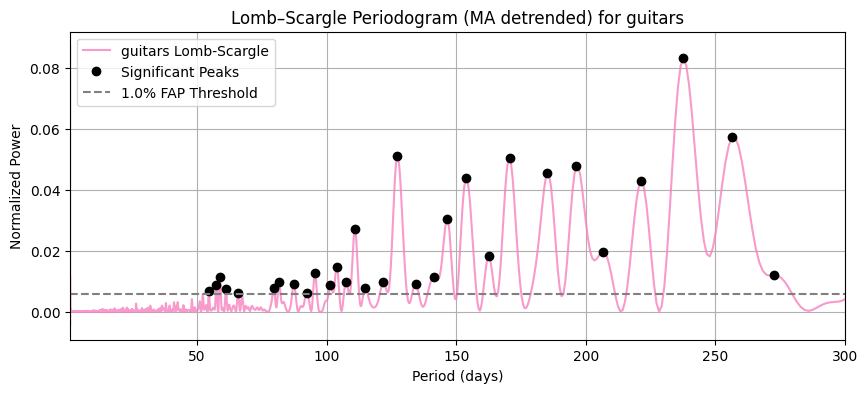

Instrument: slingshots
Significant integer periods (no duplicates): [ 59  61  65  67  79  81  91  96 100 104 108 115 125 131 141 147 155 162
 170 185 203 222 237 259 278 308 332 398 496 828]
Detailed significant peaks:
  Period = 828.03 days, Power = 0.0089, FAP = 0.00001
  Period = 496.18 days, Power = 0.0193, FAP = 0.00000
  Period = 397.55 days, Power = 0.0138, FAP = 0.00000
  Period = 331.63 days, Power = 0.0299, FAP = 0.00000
  Period = 308.06 days, Power = 0.0530, FAP = 0.00000
  Period = 278.37 days, Power = 0.0077, FAP = 0.00010
  Period = 258.96 days, Power = 0.0411, FAP = 0.00000
  Period = 236.58 days, Power = 0.0731, FAP = 0.00000
  Period = 222.41 days, Power = 0.0326, FAP = 0.00000
  Period = 203.28 days, Power = 0.0297, FAP = 0.00000
  Period = 185.19 days, Power = 0.0391, FAP = 0.00000
  Period = 170.05 days, Power = 0.0780, FAP = 0.00000
  Period = 162.09 days, Power = 0.0198, FAP = 0.00000
  Period = 154.85 days, Power = 0.0690, FAP = 0.00000
  Period = 147.39 days, P

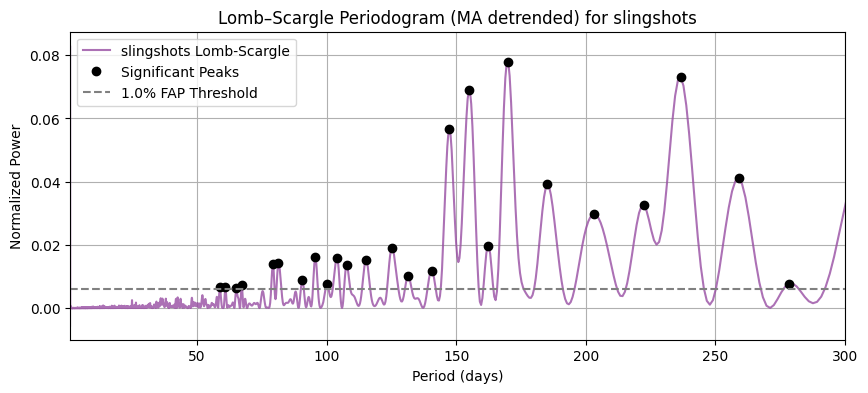

Instrument: stocks
Significant integer periods (no duplicates): [  54   55   58   59   61   68   91   93   95   98  105  110  113  116
  120  126  132  137  140  145  149  161  176  186  194  202  217  231
  256  274  292  317  352  423  461  579  756  915 1088]
Detailed significant peaks:
  Period = 1087.87 days, Power = 0.0083, FAP = 0.00002
  Period = 915.49 days, Power = 0.0067, FAP = 0.00137
  Period = 755.81 days, Power = 0.0081, FAP = 0.00004
  Period = 579.06 days, Power = 0.0107, FAP = 0.00000
  Period = 460.99 days, Power = 0.0141, FAP = 0.00000
  Period = 423.45 days, Power = 0.0278, FAP = 0.00000
  Period = 351.83 days, Power = 0.0414, FAP = 0.00000
  Period = 317.46 days, Power = 0.0416, FAP = 0.00000
  Period = 292.46 days, Power = 0.0246, FAP = 0.00000
  Period = 273.97 days, Power = 0.0235, FAP = 0.00000
  Period = 256.41 days, Power = 0.0266, FAP = 0.00000
  Period = 231.32 days, Power = 0.0578, FAP = 0.00000
  Period = 216.85 days, Power = 0.0301, FAP = 0.00000
  Peri

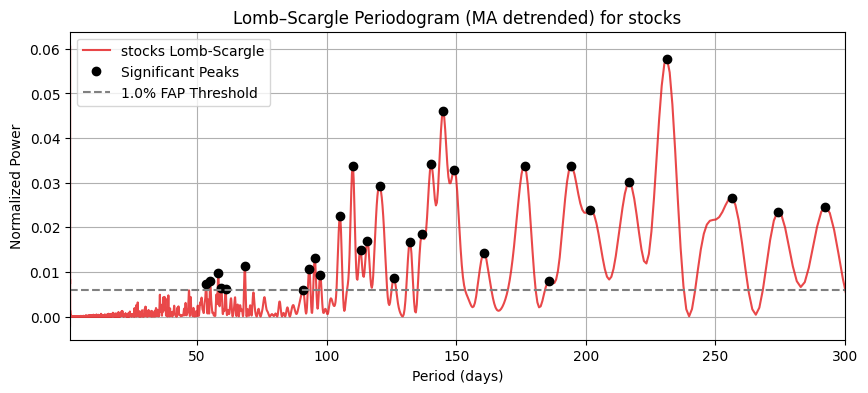

Instrument: sugar
Significant integer periods (no duplicates): [ 54  61  65  68  70  75  79  85  87  91  93  97  98 100 103 107 114 116
 122 135 141 145 150 156 164 169 183 193 202 213 226 239 254 280 297 317
 345 395 434 487 705 855]
Detailed significant peaks:
  Period = 855.26 days, Power = 0.0171, FAP = 0.00000
  Period = 704.61 days, Power = 0.0140, FAP = 0.00000
  Period = 486.89 days, Power = 0.0308, FAP = 0.00000
  Period = 434.06 days, Power = 0.0102, FAP = 0.00000
  Period = 394.54 days, Power = 0.0198, FAP = 0.00000
  Period = 344.83 days, Power = 0.0094, FAP = 0.00000
  Period = 317.46 days, Power = 0.0898, FAP = 0.00000
  Period = 297.48 days, Power = 0.0251, FAP = 0.00000
  Period = 279.87 days, Power = 0.0077, FAP = 0.00011
  Period = 253.91 days, Power = 0.0619, FAP = 0.00000
  Period = 238.75 days, Power = 0.0673, FAP = 0.00000
  Period = 226.28 days, Power = 0.0139, FAP = 0.00000
  Period = 213.29 days, Power = 0.0391, FAP = 0.00000
  Period = 201.71 days, Power = 0.0

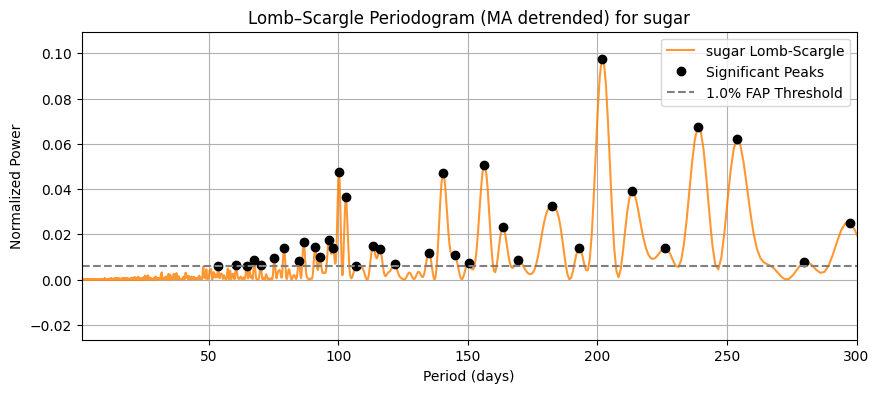

Instrument: water
Significant integer periods (no duplicates): [ 64  72  73  80  82  91  94  98 102 105 109 112 120 130 134 147 160 183
 198 207 233 251 283 325 380 420 474 592]
Detailed significant peaks:
  Period = 592.26 days, Power = 0.0198, FAP = 0.00000
  Period = 473.59 days, Power = 0.0164, FAP = 0.00000
  Period = 420.03 days, Power = 0.0265, FAP = 0.00000
  Period = 380.12 days, Power = 0.0345, FAP = 0.00000
  Period = 325.41 days, Power = 0.0649, FAP = 0.00000
  Period = 282.92 days, Power = 0.0118, FAP = 0.00000
  Period = 251.45 days, Power = 0.0827, FAP = 0.00000
  Period = 233.39 days, Power = 0.0759, FAP = 0.00000
  Period = 207.34 days, Power = 0.0598, FAP = 0.00000
  Period = 197.87 days, Power = 0.0223, FAP = 0.00000
  Period = 182.58 days, Power = 0.0571, FAP = 0.00000
  Period = 159.61 days, Power = 0.0184, FAP = 0.00000
  Period = 147.39 days, Power = 0.0091, FAP = 0.00000
  Period = 134.44 days, Power = 0.0191, FAP = 0.00000
  Period = 130.07 days, Power = 0.0172

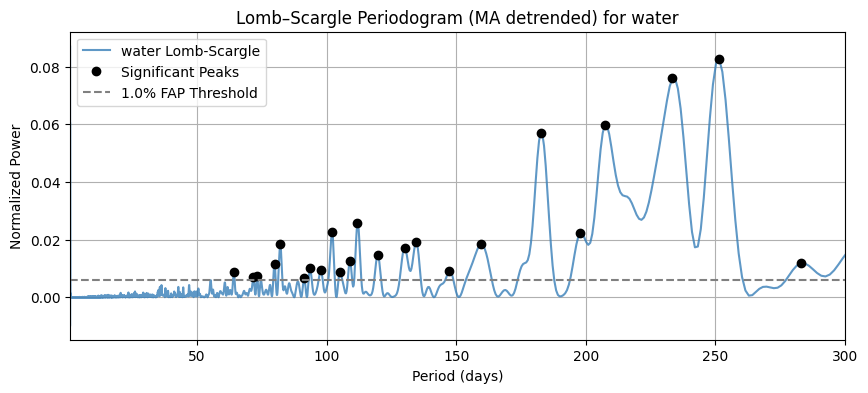

Instrument: tranquillity
Significant integer periods (no duplicates): [  63   68   78   79   89   92   94  109  113  115  125  129  132  137
  146  162  169  176  184  192  202  219  229  241  259  286  317  349
  380  427  554  668  815 1004]
Detailed significant peaks:
  Period = 1003.86 days, Power = 0.0063, FAP = 0.00394
  Period = 815.05 days, Power = 0.0077, FAP = 0.00012
  Period = 668.38 days, Power = 0.0110, FAP = 0.00000
  Period = 554.37 days, Power = 0.0178, FAP = 0.00000
  Period = 426.93 days, Power = 0.0341, FAP = 0.00000
  Period = 380.12 days, Power = 0.0522, FAP = 0.00000
  Period = 349.46 days, Power = 0.0418, FAP = 0.00000
  Period = 317.46 days, Power = 0.0741, FAP = 0.00000
  Period = 286.03 days, Power = 0.0463, FAP = 0.00000
  Period = 258.96 days, Power = 0.0286, FAP = 0.00000
  Period = 240.96 days, Power = 0.0094, FAP = 0.00000
  Period = 229.28 days, Power = 0.0257, FAP = 0.00000
  Period = 218.67 days, Power = 0.0070, FAP = 0.00069
  Period = 201.71 days, P

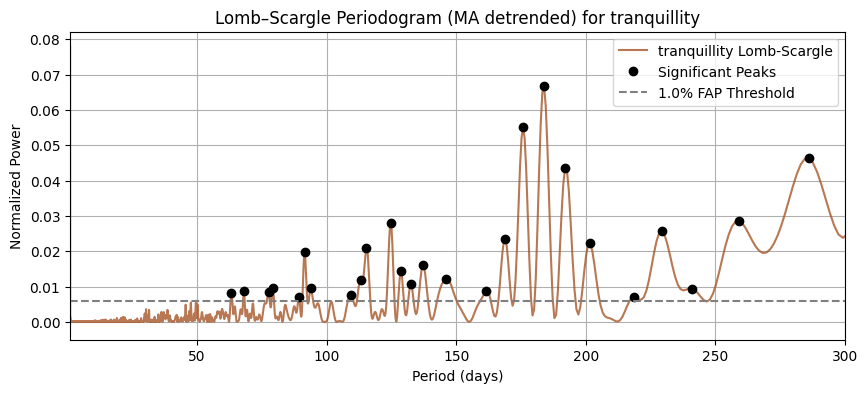

In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle

# Define the significance level for FAP filtering.
alpha = 0.01
periods_to_test = {}

# Loop over each instrument (all columns except 'day')
for col in df.columns:
    if col == 'day':
        continue
    
    # Extract the series and assign its plotting color.
    series = df[col].dropna()
    color = colours.get(col, 'black')
    
    # Moving-Average Detrending 
    window = 200 #30  # days
    trend_ma = series.rolling(window, center=True, min_periods=1).mean()
    detrended = (series - trend_ma).dropna()

    # Numeric time & zero-mean adjustment 
    t = np.arange(len(detrended))
    y = detrended.values
    y -= np.mean(y)

    # Lomb–Scargle Periodogram Calculation
    min_p, max_p = 1, 2500  # period limits in days
    ls = LombScargle(t, y)
    frequency, power = ls.autopower(
        minimum_frequency=1/max_p,
        maximum_frequency=1/min_p,
        samples_per_peak=10
    )
    period = 1.0 / frequency

    # Detect local peaks in the periodogram 
    peak_indices, _ = find_peaks(power)
    peak_freqs = frequency[peak_indices]
    peak_periods = 1.0 / peak_freqs
    peak_powers = power[peak_indices]

    # Compute False Alarm Probability (FAP) for each peak
    peak_faps = ls.false_alarm_probability(peak_powers)

    # Filter peaks by significance level α < 0.01 
    significant = peak_faps < alpha
    sig_periods = peak_periods[significant]
    sig_powers = peak_powers[significant]
    sig_faps = peak_faps[significant]

    # Round significant periods to integers, remove duplicates, and keep only values > 1
    rounded_periods = np.round(sig_periods).astype(int)
    unique_rounded_periods = np.unique(rounded_periods[rounded_periods > 1])

    # Save the candidate periods as a set into the dictionary.
    periods_to_test[col] = set(unique_rounded_periods)
    
    # Output the candidate seasonal periods 
    print(f"Instrument: {col}")
    print("Significant integer periods (no duplicates):", unique_rounded_periods)
    print("Detailed significant peaks:")
    for p, powr, fap in zip(sig_periods, sig_powers, sig_faps):
        print(f"  Period = {p:.2f} days, Power = {powr:.4f}, FAP = {fap:.5f}")
    print("\n")
    
    # Plot periodogram with significant peaks marked as red dots 
    fap_threshold = ls.false_alarm_level(alpha)
    plt.figure(figsize=(10, 4))
    plt.plot(period, power, label=f"{col} Lomb-Scargle", alpha=0.8, color=color)
    # Plot significant peaks as red dots.
    mask = sig_periods > 1.8  # Use a small buffer to avoid floating-point precision issues
    plt.plot(sig_periods[mask], sig_powers[mask], 'ko', label='Significant Peaks')
    plt.axhline(fap_threshold, linestyle="--", color="gray", 
                label=f"{alpha*100:.1f}% FAP Threshold")
    plt.xlim(1, 300)
    plt.xlabel("Period (days)")
    plt.ylabel("Normalized Power")
    plt.title(f"Lomb–Scargle Periodogram (MA detrended) for {col}")
    plt.legend()
    plt.grid(True)
    plt.show()



Analyzing: cucumbers
Significant integer periods: []



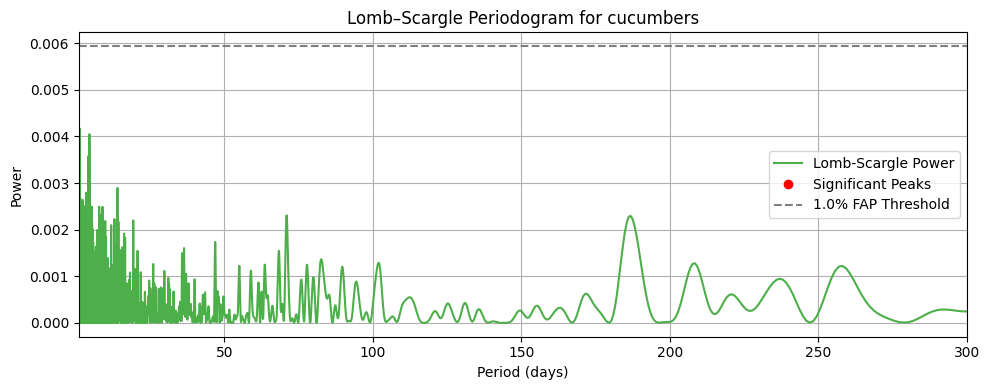

Analyzing: guitars
Significant integer periods: []



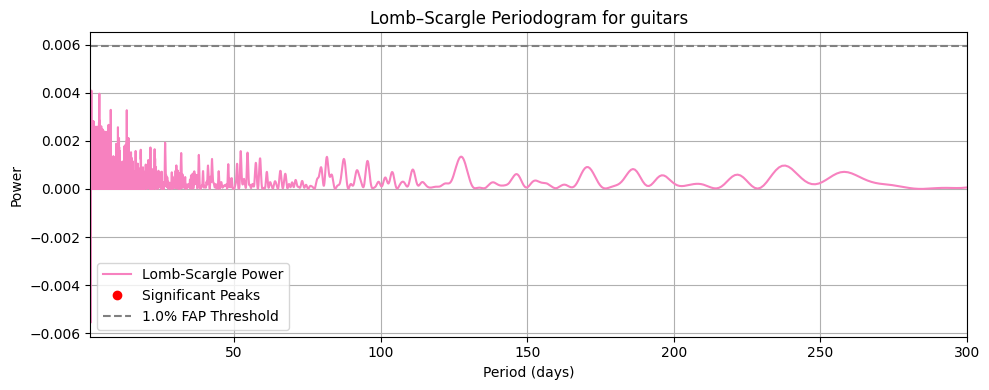

Analyzing: slingshots
Significant integer periods: []



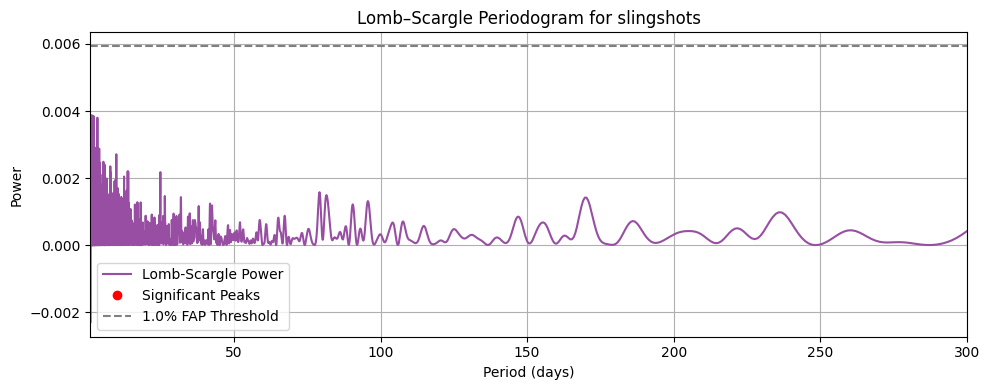

Analyzing: stocks
Significant integer periods: []



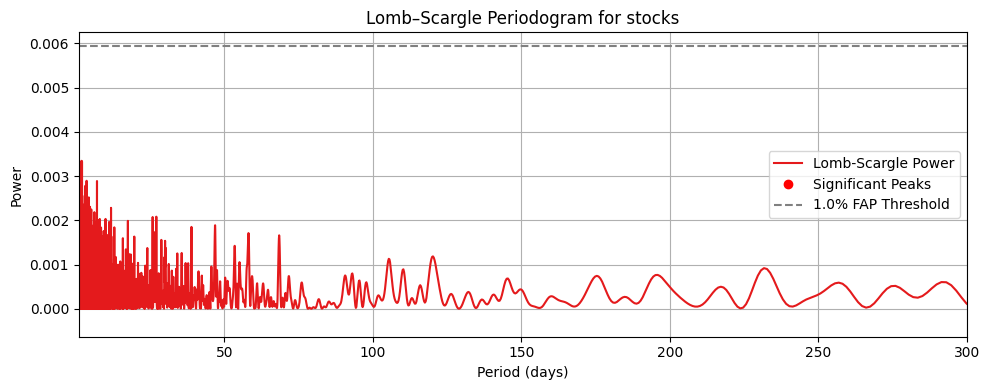

Analyzing: sugar
Significant integer periods: []



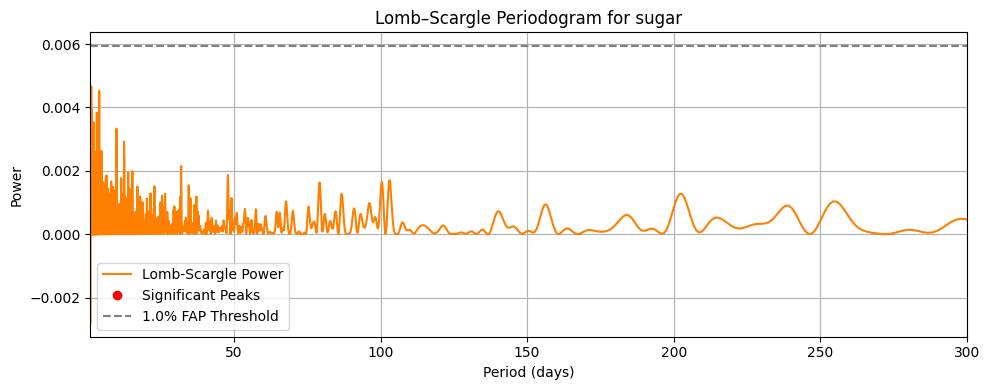

Analyzing: water
Significant integer periods: []



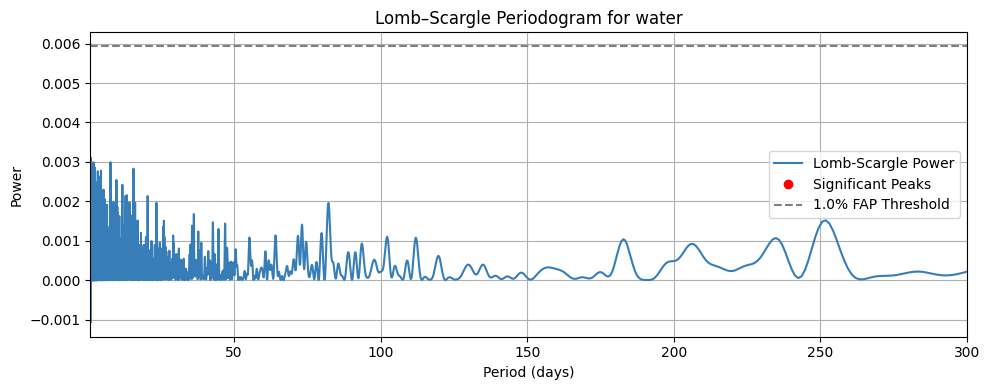

Analyzing: tranquillity
Significant integer periods: []



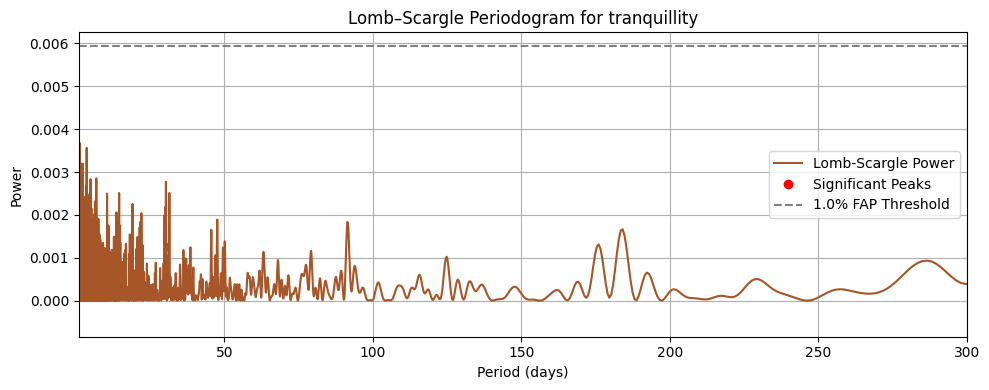

In [243]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle

# Set significance threshold for peak detection
alpha = 0.01
periods_to_test = {}

# Loop over each instrument (skip 'day' column)
for col in df.columns:
    if col == 'day':
        continue

    print(f"Analyzing: {col}")

    # Get price series
    price_series = df[col].dropna()
    color = colours.get(col, 'black')

    # Detrending
    series = np.log(price_series / price_series.shift(1)).dropna()

    # Prepare time and signal vectors
    t = np.arange(len(series))
    y = series.values - np.mean(series.values)

    # Lomb–Scargle Periodogram
    min_p, max_p = 1, 5000
    ls = LombScargle(t, y)
    frequency, power = ls.autopower(
        minimum_frequency=1/max_p,
        maximum_frequency=1/min_p,
        samples_per_peak=10
    )
    period = 1.0 / frequency

    # Peak Detection & Filtering 
    peak_indices, _ = find_peaks(power)
    peak_freqs = frequency[peak_indices]
    peak_periods = 1.0 / peak_freqs
    peak_powers = power[peak_indices]

    peak_faps = ls.false_alarm_probability(peak_powers)
    significant = peak_faps < alpha

    sig_periods = peak_periods[significant]
    sig_powers = peak_powers[significant]
    sig_faps = peak_faps[significant]

    # Round and deduplicate
    rounded_periods = np.round(sig_periods).astype(int)
    unique_rounded_periods = np.unique(rounded_periods[rounded_periods > 1])

    periods_to_test[col] = set(unique_rounded_periods)

    # Output Results
    print("Significant integer periods:", unique_rounded_periods)
    for p, powr, fap in zip(sig_periods, sig_powers, sig_faps):
        print(f"  Period = {p:.2f} days, Power = {powr:.4f}, FAP = {fap:.5f}")
    print()

    # Plot 
    fap_threshold = ls.false_alarm_level(alpha)
    plt.figure(figsize=(10, 4))
    plt.plot(period, power, label="Lomb-Scargle Power", color=color)
    plt.plot(sig_periods, sig_powers, 'ro', label='Significant Peaks')
    plt.axhline(fap_threshold, linestyle="--", color="gray", label=f"{alpha*100:.1f}% FAP Threshold")
    plt.xlim(1, 300)
    plt.xlabel("Period (days)")
    plt.ylabel("Power")
    plt.title(f"Lomb–Scargle Periodogram for {col}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [240]:
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.fft import rfft
import numpy as np

def optimal_lambda_via_fft(series, lambdas):
    """Prints all lambdas and saves the best one that minimizes low-frequency leakage."""
    best_lambda = None
    best_ratio = np.inf
    print("  λ candidates and low-frequency energy ratios:")
    
    for lam in lambdas:
        cycle, _ = hpfilter(series, lamb=lam)
        power = np.abs(rfft(cycle - cycle.mean()))**2
        low_freq_energy = np.sum(power[:10])  # tweak this cutoff as needed
        total_energy = np.sum(power)
        ratio = low_freq_energy / total_energy

        print(f"    λ = {lam:<10} | Low-freq ratio = {ratio:.6f}")
        
        if ratio < best_ratio:
            best_ratio = ratio
            best_lambda = lam

    return best_lambda, best_ratio

optimal_lambdas = {}

for col in df.columns:
    if col == 'day':
        continue

    print(f"\nAnalyzing {col}...")
    series = df[col].dropna()
    lambdas = [	100, 1600, 14400, 100000, 1000, 10000, 100000, 1e6]

    best_lambda, best_ratio = optimal_lambda_via_fft(series, lambdas)
    optimal_lambdas[col] = best_lambda

    print(f"  → Optimal λ = {best_lambda} (Low-freq ratio = {best_ratio:.6f})")



Analyzing cucumbers...
  λ candidates and low-frequency energy ratios:
    λ = 100        | Low-freq ratio = 0.000000
    λ = 1600       | Low-freq ratio = 0.000000
    λ = 14400      | Low-freq ratio = 0.000000
    λ = 100000     | Low-freq ratio = 0.000002
    λ = 1000       | Low-freq ratio = 0.000000
    λ = 10000      | Low-freq ratio = 0.000000
    λ = 100000     | Low-freq ratio = 0.000002
    λ = 1000000.0  | Low-freq ratio = 0.000092
  → Optimal λ = 100 (Low-freq ratio = 0.000000)

Analyzing guitars...
  λ candidates and low-frequency energy ratios:
    λ = 100        | Low-freq ratio = 0.000000
    λ = 1600       | Low-freq ratio = 0.000000
    λ = 14400      | Low-freq ratio = 0.000000
    λ = 100000     | Low-freq ratio = 0.000001
    λ = 1000       | Low-freq ratio = 0.000000
    λ = 10000      | Low-freq ratio = 0.000000
    λ = 100000     | Low-freq ratio = 0.000001
    λ = 1000000.0  | Low-freq ratio = 0.000080
  → Optimal λ = 100 (Low-freq ratio = 0.000000)

Analyzing

Analyzing: cucumbers
Significant integer periods: [10 12 13 14 15 16 19]
  Period = 19.34 days, Power = 0.0060, FAP = 0.00866
  Period = 16.26 days, Power = 0.0067, FAP = 0.00140
  Period = 14.97 days, Power = 0.0074, FAP = 0.00024
  Period = 14.34 days, Power = 0.0072, FAP = 0.00036
  Period = 14.01 days, Power = 0.0118, FAP = 0.00000
  Period = 13.89 days, Power = 0.0066, FAP = 0.00182
  Period = 13.00 days, Power = 0.0081, FAP = 0.00004
  Period = 11.91 days, Power = 0.0068, FAP = 0.00104
  Period = 9.91 days, Power = 0.0068, FAP = 0.00103
  Period = 1.11 days, Power = 0.0071, FAP = 0.00046
  Period = 1.09 days, Power = 0.0072, FAP = 0.00042
  Period = 1.08 days, Power = 0.0085, FAP = 0.00002
  Period = 1.08 days, Power = 0.0070, FAP = 0.00074
  Period = 1.08 days, Power = 0.0122, FAP = 0.00000
  Period = 1.07 days, Power = 0.0077, FAP = 0.00012
  Period = 1.07 days, Power = 0.0077, FAP = 0.00011
  Period = 1.07 days, Power = 0.0069, FAP = 0.00078
  Period = 1.05 days, Power = 0.006

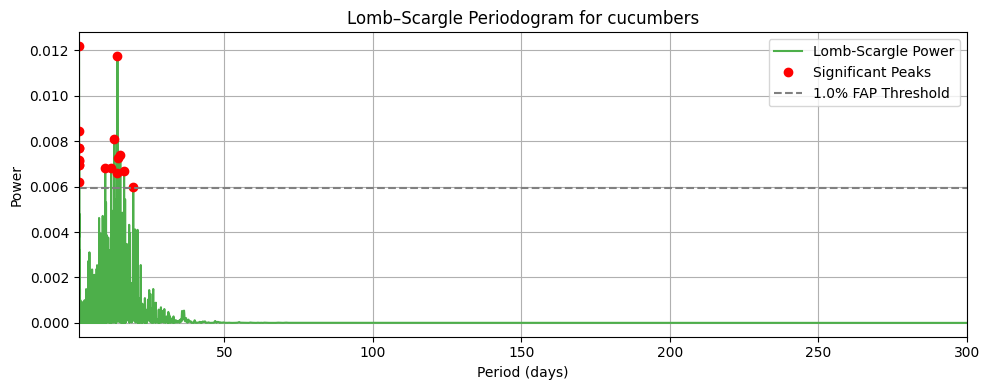

Analyzing: guitars
Significant integer periods: [ 8 10 13 14 16 18]
  Period = 18.25 days, Power = 0.0069, FAP = 0.00082
  Period = 16.43 days, Power = 0.0063, FAP = 0.00357
  Period = 14.02 days, Power = 0.0078, FAP = 0.00009
  Period = 13.95 days, Power = 0.0085, FAP = 0.00001
  Period = 13.74 days, Power = 0.0060, FAP = 0.00900
  Period = 13.46 days, Power = 0.0066, FAP = 0.00183
  Period = 13.41 days, Power = 0.0124, FAP = 0.00000
  Period = 12.52 days, Power = 0.0079, FAP = 0.00006
  Period = 10.40 days, Power = 0.0066, FAP = 0.00174
  Period = 9.88 days, Power = 0.0068, FAP = 0.00122
  Period = 9.79 days, Power = 0.0060, FAP = 0.00787
  Period = 7.94 days, Power = 0.0059, FAP = 0.00989
  Period = 1.14 days, Power = 0.0061, FAP = 0.00675
  Period = 1.11 days, Power = 0.0063, FAP = 0.00353
  Period = 1.11 days, Power = 0.0071, FAP = 0.00048
  Period = 1.11 days, Power = 0.0070, FAP = 0.00073
  Period = 1.09 days, Power = 0.0083, FAP = 0.00002
  Period = 1.08 days, Power = 0.0128, F

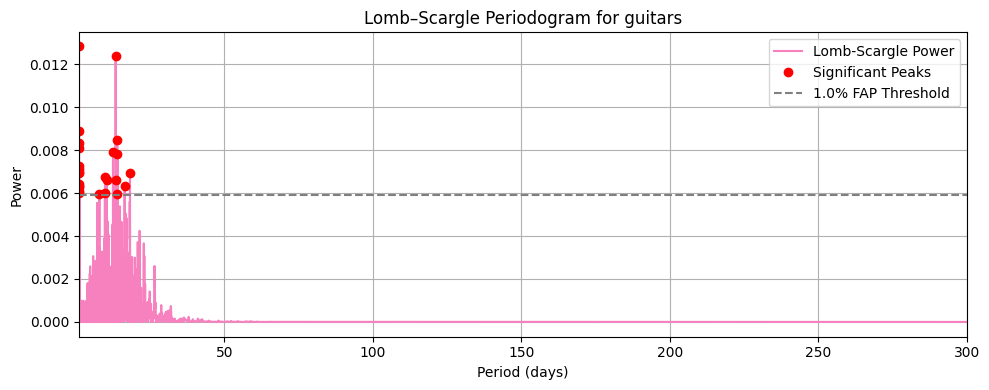

Analyzing: slingshots
Significant integer periods: [10 13 14]
  Period = 13.94 days, Power = 0.0085, FAP = 0.00001
  Period = 13.75 days, Power = 0.0104, FAP = 0.00000
  Period = 13.56 days, Power = 0.0076, FAP = 0.00015
  Period = 13.41 days, Power = 0.0074, FAP = 0.00023
  Period = 12.52 days, Power = 0.0078, FAP = 0.00008
  Period = 9.88 days, Power = 0.0089, FAP = 0.00000
  Period = 1.12 days, Power = 0.0061, FAP = 0.00735
  Period = 1.11 days, Power = 0.0094, FAP = 0.00000
  Period = 1.09 days, Power = 0.0061, FAP = 0.00583
  Period = 1.09 days, Power = 0.0082, FAP = 0.00003
  Period = 1.08 days, Power = 0.0078, FAP = 0.00010
  Period = 1.08 days, Power = 0.0081, FAP = 0.00005
  Period = 1.08 days, Power = 0.0110, FAP = 0.00000
  Period = 1.08 days, Power = 0.0091, FAP = 0.00000



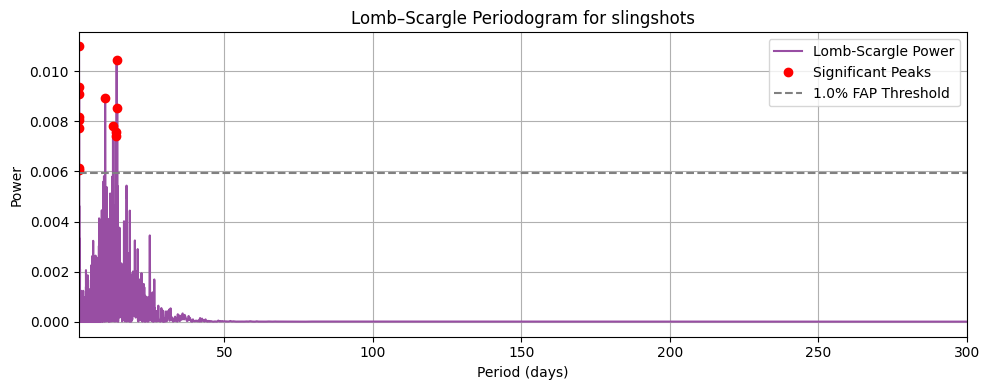

Analyzing: stocks
Significant integer periods: [12 13 16]
  Period = 15.84 days, Power = 0.0070, FAP = 0.00062
  Period = 12.96 days, Power = 0.0074, FAP = 0.00027
  Period = 11.95 days, Power = 0.0066, FAP = 0.00207
  Period = 1.11 days, Power = 0.0061, FAP = 0.00744
  Period = 1.10 days, Power = 0.0060, FAP = 0.00950
  Period = 1.10 days, Power = 0.0063, FAP = 0.00421
  Period = 1.09 days, Power = 0.0068, FAP = 0.00117
  Period = 1.08 days, Power = 0.0077, FAP = 0.00012
  Period = 1.07 days, Power = 0.0061, FAP = 0.00727
  Period = 1.07 days, Power = 0.0074, FAP = 0.00023
  Period = 1.06 days, Power = 0.0060, FAP = 0.00908



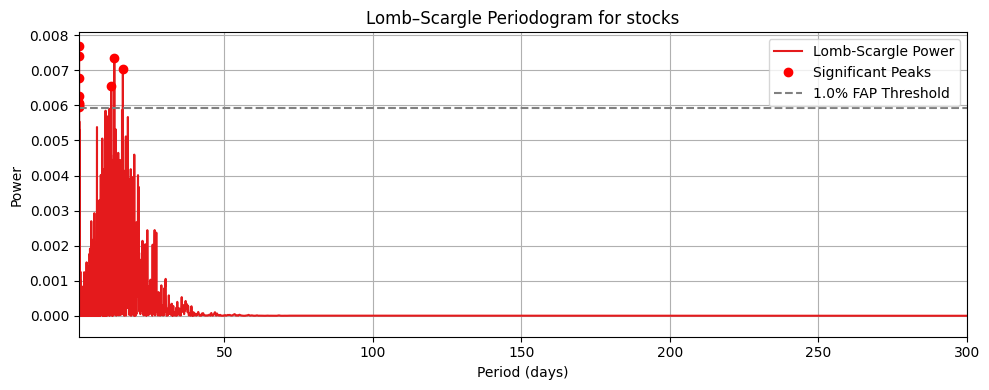

Analyzing: sugar
Significant integer periods: [10 12 13 14 15]
  Period = 15.36 days, Power = 0.0074, FAP = 0.00025
  Period = 14.70 days, Power = 0.0063, FAP = 0.00359
  Period = 13.94 days, Power = 0.0068, FAP = 0.00121
  Period = 12.53 days, Power = 0.0095, FAP = 0.00000
  Period = 11.56 days, Power = 0.0060, FAP = 0.00917
  Period = 9.93 days, Power = 0.0117, FAP = 0.00000
  Period = 1.11 days, Power = 0.0060, FAP = 0.00800
  Period = 1.11 days, Power = 0.0122, FAP = 0.00000
  Period = 1.09 days, Power = 0.0063, FAP = 0.00404
  Period = 1.09 days, Power = 0.0061, FAP = 0.00717
  Period = 1.09 days, Power = 0.0098, FAP = 0.00000
  Period = 1.08 days, Power = 0.0071, FAP = 0.00049
  Period = 1.07 days, Power = 0.0062, FAP = 0.00508
  Period = 1.07 days, Power = 0.0066, FAP = 0.00164
  Period = 1.07 days, Power = 0.0077, FAP = 0.00010
  Period = 1.06 days, Power = 0.0060, FAP = 0.00758



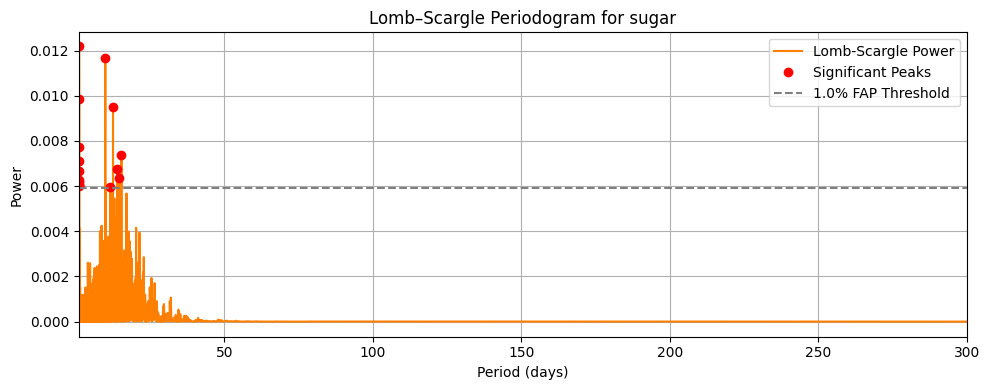

Analyzing: water
Significant integer periods: [10 12 13 14 15 16]
  Period = 16.25 days, Power = 0.0060, FAP = 0.00770
  Period = 15.69 days, Power = 0.0085, FAP = 0.00002
  Period = 15.01 days, Power = 0.0064, FAP = 0.00276
  Period = 14.32 days, Power = 0.0070, FAP = 0.00075
  Period = 13.47 days, Power = 0.0070, FAP = 0.00060
  Period = 13.00 days, Power = 0.0079, FAP = 0.00007
  Period = 12.92 days, Power = 0.0061, FAP = 0.00629
  Period = 11.91 days, Power = 0.0081, FAP = 0.00004
  Period = 10.20 days, Power = 0.0064, FAP = 0.00300
  Period = 10.18 days, Power = 0.0065, FAP = 0.00238
  Period = 9.88 days, Power = 0.0070, FAP = 0.00075
  Period = 1.11 days, Power = 0.0074, FAP = 0.00026
  Period = 1.11 days, Power = 0.0069, FAP = 0.00091
  Period = 1.11 days, Power = 0.0067, FAP = 0.00131
  Period = 1.09 days, Power = 0.0086, FAP = 0.00001
  Period = 1.08 days, Power = 0.0064, FAP = 0.00312
  Period = 1.08 days, Power = 0.0083, FAP = 0.00002
  Period = 1.08 days, Power = 0.0060, FA

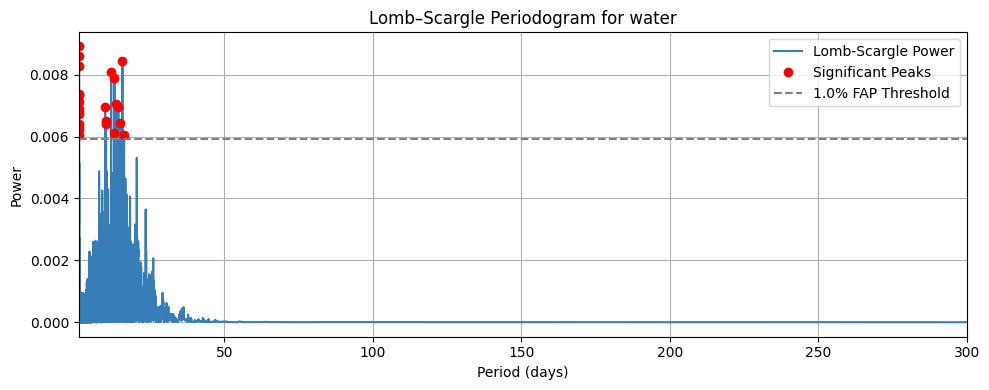

Analyzing: tranquillity
Significant integer periods: [11 13 14 15 19]
  Period = 19.09 days, Power = 0.0065, FAP = 0.00244
  Period = 14.67 days, Power = 0.0063, FAP = 0.00426
  Period = 14.59 days, Power = 0.0074, FAP = 0.00025
  Period = 13.68 days, Power = 0.0079, FAP = 0.00006
  Period = 12.83 days, Power = 0.0063, FAP = 0.00415
  Period = 10.52 days, Power = 0.0072, FAP = 0.00037
  Period = 1.11 days, Power = 0.0075, FAP = 0.00021
  Period = 1.08 days, Power = 0.0066, FAP = 0.00192
  Period = 1.08 days, Power = 0.0083, FAP = 0.00002
  Period = 1.07 days, Power = 0.0077, FAP = 0.00013
  Period = 1.07 days, Power = 0.0066, FAP = 0.00176
  Period = 1.06 days, Power = 0.0067, FAP = 0.00131



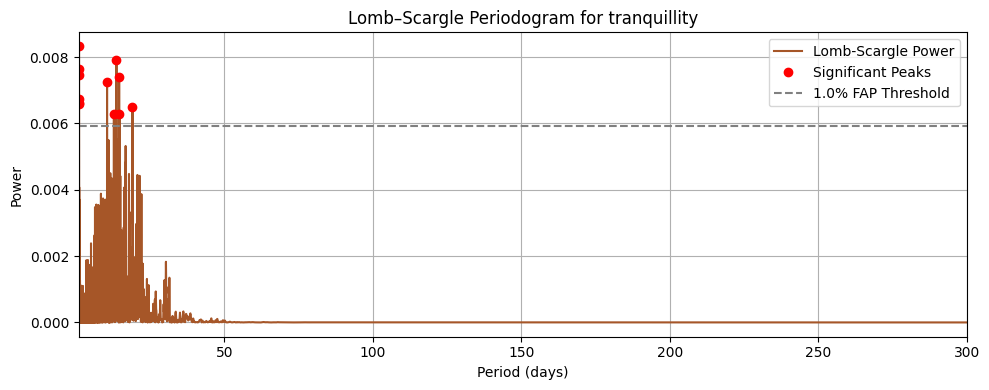

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle

# Set significance threshold for peak detection
alpha = 0.01
periods_to_test = {}

# Loop over each instrument (skip 'day' column)
for col in df.columns:
    if col == 'day':
        continue

    print(f"Analyzing: {col}")

    # Get price series
    price_series = df[col].dropna()
    color = colours.get(col, 'black')

    # Detrending
    from statsmodels.tsa.filters.hp_filter import hpfilter
    cycle, _ = hpfilter(price_series, lamb=100)
    series = cycle.dropna()

    # Prepare time and signal vectors
    t = np.arange(len(series))
    y = series.values - np.mean(series.values)

    # Lomb–Scargle Periodogram
    min_p, max_p = 1, 5000
    ls = LombScargle(t, y)
    frequency, power = ls.autopower(
        minimum_frequency=1/max_p,
        maximum_frequency=1/min_p,
        samples_per_peak=10
    )
    period = 1.0 / frequency

    # Peak Detection & Filtering 
    peak_indices, _ = find_peaks(power)
    peak_freqs = frequency[peak_indices]
    peak_periods = 1.0 / peak_freqs
    peak_powers = power[peak_indices]

    peak_faps = ls.false_alarm_probability(peak_powers)
    significant = peak_faps < alpha

    sig_periods = peak_periods[significant]
    sig_powers = peak_powers[significant]
    sig_faps = peak_faps[significant]

    # Round and deduplicate
    rounded_periods = np.round(sig_periods).astype(int)
    unique_rounded_periods = np.unique(rounded_periods[rounded_periods > 1])

    periods_to_test[col] = set(unique_rounded_periods)

    # Output Results
    print("Significant integer periods:", unique_rounded_periods)
    for p, powr, fap in zip(sig_periods, sig_powers, sig_faps):
        print(f"  Period = {p:.2f} days, Power = {powr:.4f}, FAP = {fap:.5f}")
    print()

    # Plot
    fap_threshold = ls.false_alarm_level(alpha)
    plt.figure(figsize=(10, 4))
    plt.plot(period, power, label="Lomb-Scargle Power", color=color)
    plt.plot(sig_periods, sig_powers, 'ro', label='Significant Peaks')
    plt.axhline(fap_threshold, linestyle="--", color="gray", label=f"{alpha*100:.1f}% FAP Threshold")
    plt.xlim(1, 300)
    plt.xlabel("Period (days)")
    plt.ylabel("Power")
    plt.title(f"Lomb–Scargle Periodogram for {col}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Analyzing cucumbers...
Tested Period 11 days: Strength = 0.186
Tested Period 13 days: Strength = 0.184
Tested Period 14 days: Strength = 0.206
Tested Period 15 days: Strength = 0.203
Tested Period 19 days: Strength = 0.200
Best Period: 14 days (Strength: 0.206)

Analyzing guitars...
Tested Period 11 days: Strength = 0.167
Tested Period 13 days: Strength = 0.184
Tested Period 14 days: Strength = 0.170
Tested Period 15 days: Strength = 0.170
Tested Period 19 days: Strength = 0.173
Best Period: 13 days (Strength: 0.184)

Analyzing slingshots...
Tested Period 11 days: Strength = 0.181
Tested Period 13 days: Strength = 0.181
Tested Period 14 days: Strength = 0.173
Tested Period 15 days: Strength = 0.169
Tested Period 19 days: Strength = 0.193
Best Period: 19 days (Strength: 0.193)

Analyzing stocks...
Tested Period 11 days: Strength = 0.169
Tested Period 13 days: Strength = 0.176
Tested Period 14 days: Strength = 0.189
Tested Period 15 days: Strength = 0.194
Tested Period 19 days: Strength

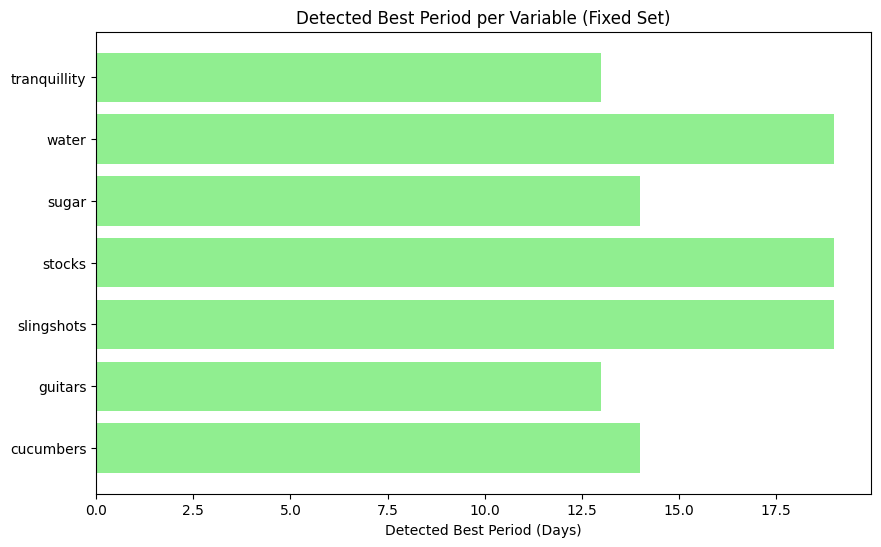

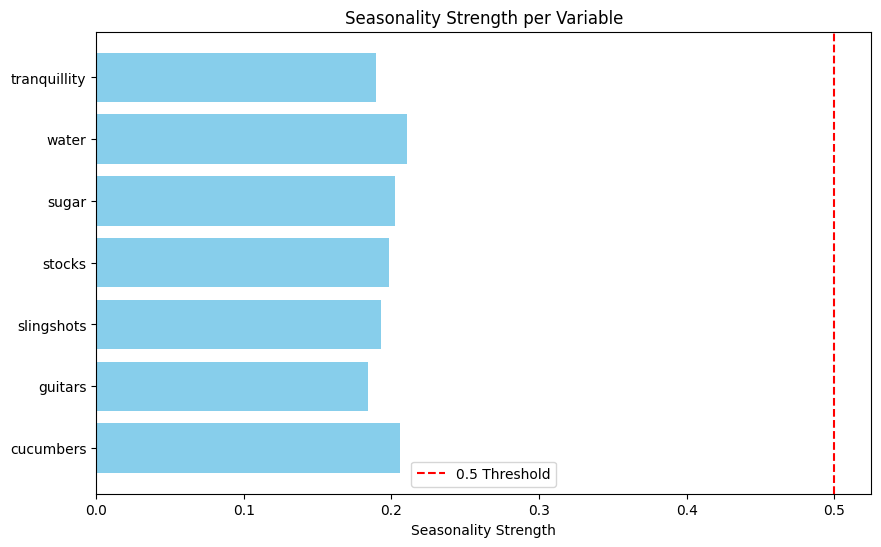

In [246]:
from statsmodels.tsa.seasonal import STL
# Fixed periods to test
periods = periods_to_test[col]

def calculate_seasonality_strength(result):
    """Strength = variance of seasonal / (variance of seasonal + variance of residual)"""
    seasonal_var = np.var(result.seasonal)
    residual_var = np.var(result.resid)
    return seasonal_var / (seasonal_var + residual_var)

def best_fixed_period(series, periods_to_test):
    """Find best period among a fixed set."""
    best_strength = -np.inf
    best_period = None
    
    for test_period in periods_to_test:
        if test_period >= len(series.dropna()) // 2:
            continue  # Skip if period is too long for data

        try:
            stl = STL(series, period=test_period, robust=True)
            result = stl.fit()
            strength = calculate_seasonality_strength(result)
            print(f"Tested Period {test_period} days: Strength = {strength:.3f}")
            
            if strength > best_strength:
                best_strength = strength
                best_period = test_period
        except Exception as e:
            print(f"Error testing period {test_period}: {e}")
            continue

    return best_period, best_strength

# --- Analysis ---

best_periods = {}
seasonality_strengths = {}

for col in df.columns:
    if col == 'day':
        continue
    print(f"\nAnalyzing {col}...")
    series = df[col].dropna()
    
    best_period, best_strength = best_fixed_period(series, periods)
    
    if best_period is None:
        print(f"No good period found for {col}. Skipping.")
        continue

    best_periods[col] = best_period
    seasonality_strengths[col] = best_strength
    print(f"Best Period: {best_period} days (Strength: {best_strength:.3f})")

# --- Results ---

# Plot best periods
plt.figure(figsize=(10, 6))
plt.barh(list(best_periods.keys()), list(best_periods.values()), color='lightgreen')
plt.xlabel("Detected Best Period (Days)")
plt.title("Detected Best Period per Variable (Fixed Set)")
plt.show()

# Plot seasonality strength
plt.figure(figsize=(10, 6))
plt.barh(list(seasonality_strengths.keys()), list(seasonality_strengths.values()), color='skyblue')
plt.xlabel("Seasonality Strength")
plt.title("Seasonality Strength per Variable")
plt.axvline(0.5, color='red', linestyle='--', label='0.5 Threshold')
plt.legend()
plt.show()



Processing cucumbers...
Guerrero Box-Cox λ for cucumbers: -2.0000

Processing guitars...
Guerrero Box-Cox λ for guitars: -1.9036

Processing slingshots...
Guerrero Box-Cox λ for slingshots: -1.9690

Processing stocks...
Guerrero Box-Cox λ for stocks: -1.8994

Processing sugar...
Guerrero Box-Cox λ for sugar: -1.9372

Processing water...
Guerrero Box-Cox λ for water: -2.0000

Processing tranquillity...
Guerrero Box-Cox λ for tranquillity: -1.8249

Analyzing cucumbers...
Tested Period 256 days: Strength = 0.270
Tested Period 386 days: Strength = 0.247
Tested Period 131 days: Strength = 0.166
Tested Period 136 days: Strength = 0.187
Tested Period 149 days: Strength = 0.191
Tested Period 156 days: Strength = 0.173
Tested Period 163 days: Strength = 0.192
Tested Period 427 days: Strength = 0.312
Tested Period 172 days: Strength = 0.213
Tested Period 304 days: Strength = 0.191
Tested Period 55 days: Strength = 0.184
Tested Period 59 days: Strength = 0.191
Tested Period 187 days: Strength = 

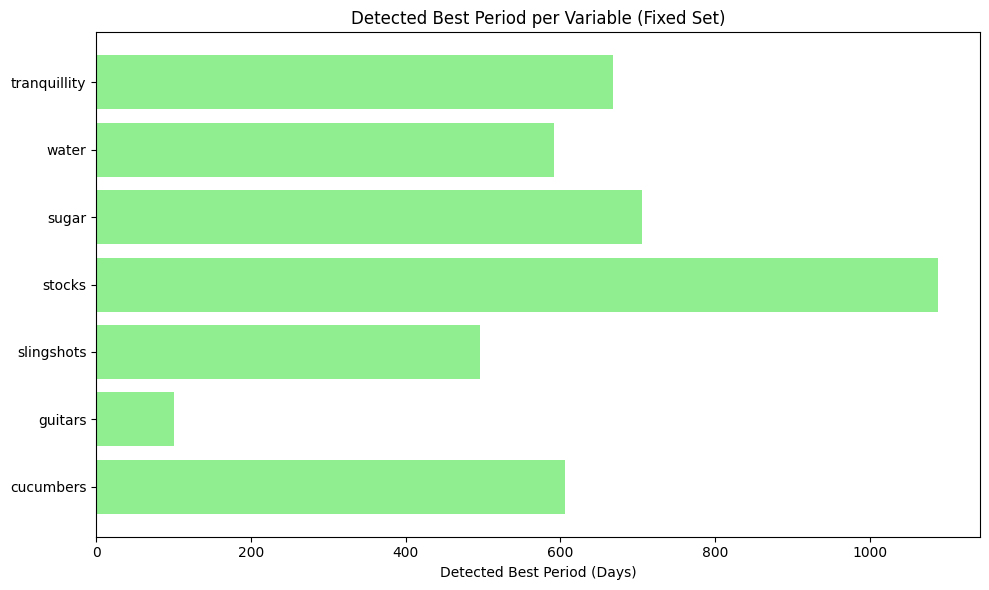

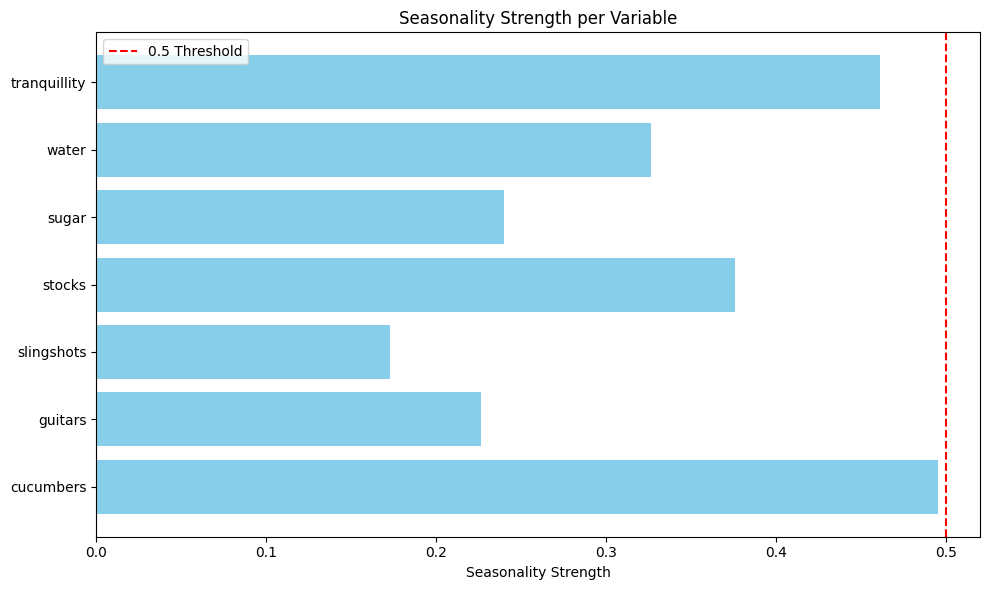

In [225]:
from statsmodels.tsa.seasonal import STL
from scipy.stats import boxcox
import numpy as np
import matplotlib.pyplot as plt

def guerrero_lambda(series, period):
    """Approximate Guerrero method for Box-Cox lambda selection."""
    series = series.dropna()
    rolling_var = series.rolling(window=period, center=True).var()
    mean_var_ratio = rolling_var.mean() / series.var()
    return max(-2, min(2, np.log(mean_var_ratio)))

transformed_data = {}
lambda_values = {}
best_periods = {}
seasonality_strengths = {}

for col in df.columns:
    if col == 'day':
        continue

    print(f"\nProcessing {col}...")
    series = df[col].dropna()
    
    # Use a different variable name to hold the list of periods for this column
    periods_for_col = list(periods_to_test.get(col, []))

    if not periods_for_col:
        print(f"No valid periods found for {col}. Skipping.")
        continue

    # Skip Box-Cox if series has non-positive values
    if (series <= 0).any():
        print(f"{col} contains non-positive values. Skipping Box-Cox.")
        continue

    # Calculate Guerrero-based lambda as average over all periods
    lambda_guerrero = np.mean([guerrero_lambda(series, p) for p in periods_for_col])

    try:
        transformed_series = boxcox(series, lmbda=lambda_guerrero)
        transformed_data[col] = transformed_series
        lambda_values[col] = lambda_guerrero
        print(f"Guerrero Box-Cox λ for {col}: {lambda_guerrero:.4f}")
    except Exception as e:
        print(f"Error transforming {col}: {e}")
        continue

# Convert transformed data dict to DataFrame
transformed_df = pd.DataFrame(transformed_data)

# Analyze seasonality on transformed data
for col in transformed_df.columns:
    print(f"\nAnalyzing {col}...")
    series = pd.Series(transformed_df[col]).dropna()
    
    # Again get the periods for this column safely
    periods_for_col = list(periods_to_test.get(col, []))
    
    if not periods_for_col:
        print(f"No candidate periods found for {col}. Skipping.")
        continue
    
    best_period, best_strength = best_fixed_period(series, periods_for_col)
    
    if best_period is None:
        print(f"No good period found for {col}. Skipping.")
        continue
    
    best_periods[col] = best_period
    seasonality_strengths[col] = best_strength
    print(f"Best Period: {best_period} days (Strength: {best_strength:.3f})")

# --- Plot Results ---

plt.figure(figsize=(10, 6))
plt.barh(list(best_periods.keys()), list(best_periods.values()), color='lightgreen')
plt.xlabel("Detected Best Period (Days)")
plt.title("Detected Best Period per Variable (Fixed Set)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(list(seasonality_strengths.keys()), list(seasonality_strengths.values()), color='skyblue')
plt.xlabel("Seasonality Strength")
plt.title("Seasonality Strength per Variable")
plt.axvline(0.5, color='red', linestyle='--', label='0.5 Threshold')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import boxcox

# --- Box-Cox Guerrero Lambda Function ---
def guerrero_lambda(series, period):
    """Approximate Guerrero method for Box-Cox lambda selection."""
    series = series.dropna()
    rolling_var = series.rolling(window=period, center=True).var()
    mean_var_ratio = rolling_var.mean() / series.var()
    return max(-2, min(2, np.log(mean_var_ratio)))

# Define the full range of candidate periods (here: 2 to 400 days)
all_possible_periods = np.arange(2, 2000)

# --- Transformation + Seasonality Strength Analysis ---
transformed_data = {}
lambda_values = {}
best_periods = {}
seasonality_strengths = {}

# Use raw data for transformation and seasonality analysis
for col in df.columns:
    if col == 'day':
        continue

    print(f"\nProcessing {col}...")
    series = df[col].dropna()

    # Use all possible periods instead of stored candidate periods.
    candidate_periods = all_possible_periods

    if candidate_periods.size == 0:
        print(f"No valid periods found for {col}. Skipping.")
        continue

    if (series <= 0).any():
        print(f"{col} contains non-positive values. Skipping Box-Cox.")
        continue

    # Calculate Guerrero-based lambda by averaging over all candidate periods.
    lambda_guerrero = np.mean([guerrero_lambda(series, p) for p in candidate_periods])
    
    try:
        transformed_series = boxcox(series, lmbda=lambda_guerrero)
        transformed_data[col] = transformed_series
        lambda_values[col] = lambda_guerrero
        print(f"Guerrero Box-Cox λ for {col}: {lambda_guerrero:.4f}")
    except Exception as e:
        print(f"Error transforming {col}: {e}")
        continue

    # Run seasonality strength analysis on the raw series using all_possible_periods.
    best_period, best_strength = best_fixed_period(series, candidate_periods)
    if best_period is None:
        print(f"No good period found for {col}. Skipping.")
        continue

    best_periods[col] = best_period
    seasonality_strengths[col] = best_strength
    print(f"Best Period: {best_period} days (Strength: {best_strength:.3f})")

# Convert the transformed_data dictionary to a DataFrame.
transformed_df = pd.DataFrame(transformed_data)

# --- Analyze Seasonality on Transformed Data ---
for col in transformed_df.columns:
    print(f"\nAnalyzing {col} on transformed data...")
    series = pd.Series(transformed_df[col]).dropna()
    
    # Use the same full range of candidate periods.
    candidate_periods = all_possible_periods
    
    best_period, best_strength = best_fixed_period(series, candidate_periods)
    if best_period is None:
        print(f"No good period found for {col}. Skipping.")
        continue

    best_periods[col] = best_period  # Overwrite or add additional info as desired.
    seasonality_strengths[col] = best_strength
    print(f"Best Period: {best_period} days (Strength: {best_strength:.3f})")

# --- Plot Results ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(list(best_periods.keys()), list(best_periods.values()), color='lightgreen')
plt.xlabel("Detected Best Period (Days)")
plt.title("Detected Best Period per Variable (All Possible Periods)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(list(seasonality_strengths.keys()), list(seasonality_strengths.values()), color='skyblue')
plt.xlabel("Seasonality Strength")
plt.title("Seasonality Strength per Variable (All Possible Periods)")
plt.axvline(0.5, color='red', linestyle='--', label='0.5 Threshold')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.seasonal import STL
import numpy as np
import matplotlib.pyplot as plt

def calculate_seasonality_strength(result):
    """Strength = variance of seasonal / (variance of seasonal + variance of residual)"""
    seasonal_var = np.var(result.seasonal)
    residual_var = np.var(result.resid)
    return seasonal_var / (seasonal_var + residual_var)

def best_period_full_search(series):
    """Find best period by testing all integer periods up to half the length of the series."""
    series = series.dropna()
    max_period = len(series) // 2
    best_strength = -np.inf
    best_period = None

    for test_period in range(1, max_period + 1):
        try:
            stl = STL(series, period=test_period, robust=True)
            result = stl.fit()
            strength = calculate_seasonality_strength(result)
            
            if strength > best_strength:
                best_strength = strength
                best_period = test_period
        except Exception as e:
            # Skip problematic periods (e.g., too short)
            continue

    return best_period, best_strength

# --- Analysis ---
best_periods = {}
seasonality_strengths = {}

for col in df.columns:
    if col == 'day':
        continue
    print(f"\nAnalyzing {col}...")
    series = log_returns[col]
    
    best_period, best_strength = best_period_full_search(series)
    
    if best_period is None:
        print(f"No good period found for {col}. Skipping.")
        continue

    best_periods[col] = best_period
    seasonality_strengths[col] = best_strength
    print(f"Best Period: {best_period} days (Strength: {best_strength:.3f})")

# --- Results ---

plt.figure(figsize=(10, 6))
plt.barh(list(best_periods.keys()), list(best_periods.values()), color='lightgreen')
plt.xlabel("Detected Best Period (Days)")
plt.title("Best Period per Variable (Full Search)")
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(list(seasonality_strengths.keys()), list(seasonality_strengths.values()), color='skyblue')
plt.xlabel("Seasonality Strength")
plt.title("Seasonality Strength per Variable")
plt.axvline(0.5, color='red', linestyle='--', label='0.5 Threshold')
plt.legend()
plt.show()



Analyzing cucumbers...
